In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, MultiHeadAttention, Dense
from keras.models import Model
from training.lib.layers import ForexPrep, FloatEmbedding, PositionalEncoding

import os


In [29]:
DATA_PATH = os.path.abspath("training/Data/daily_csv.csv")
COUNTRY = "United Kingdom"
SEQ_LEN = 59
BATCH_SIZE = 64
EPOCHS = 15
HEADS = 6
EMBEDDING_UNITS = 50
AVERAGING_GAP = 7
FEED_FORWARD_DENSE_LAYERS = [30, 10]
SPLIT_RATIO = 0.33


In [25]:
def load_data(path=DATA_PATH, country=COUNTRY) -> np.ndarray:
	df = pd.read_csv(path)
	df = df.dropna()
	df = df[df["Country"] == country]
	return df["Value"].to_numpy()


In [70]:
def create_model(seq_len=SEQ_LEN, heads=HEADS, averaging_gap=AVERAGING_GAP, embedding_units=EMBEDDING_UNITS, ff_dense_layers=FEED_FORWARD_DENSE_LAYERS) -> Model:
	input0 = Input(shape=(seq_len, 1))
	prep = ForexPrep(average_gap=averaging_gap)(input0)
	embedding = FloatEmbedding(embedding_units)(prep)
	positional_encoding = PositionalEncoding()(embedding)
	multi_head = MultiHeadAttention(heads, seq_len)(positional_encoding, positional_encoding)
	ff_dense = Dense(ff_dense_layers[0])(multi_head)
	for units in ff_dense_layers[1:]:
		ff_dense = Dense(units)(ff_dense)
	shrink_dense = Dense(1)(ff_dense)
	reshaped = tf.reshape(shrink_dense, (-1, shrink_dense.shape[1]))
	ff_dense = Dense(ff_dense_layers[0])(reshaped)
	for units in ff_dense_layers[1:]:
		ff_dense = Dense(units)(ff_dense)
	output = tf.reshape(Dense(1)(ff_dense), (-1,))
	
	return Model(inputs=input0, outputs=output)


In [13]:
def prepare_data(data: np.ndarray, seq_len=SEQ_LEN):
	if len(data.shape) == 2:
		data = data.reshape((-1,))
	
	data_len = data.shape[0] - seq_len
	
	X = np.zeros((data_len, seq_len))
	y = np.zeros((data_len,))
	
	for i in range(data_len):
		X[i] = data[i:i+seq_len]
		y[i] = data[i+seq_len]
	
	return X, y


In [12]:
def split_data(X, y, split_ratio=SPLIT_RATIO):
	test_size = int(split_ratio*X.shape[0])
	return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
	

In [48]:
data = load_data()
X, y = prepare_data(data)
X_train, X_test, y_train, y_test = split_data(X, y)


In [71]:
model = create_model()
model.compile(optimizer="adam", loss="mse")

In [72]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 59, 1)]      0                                            
__________________________________________________________________________________________________
forex_prep_5 (ForexPrep)        (None, 52, 2)        0           input_6[0][0]                    
__________________________________________________________________________________________________
float_embedding_5 (FloatEmbeddi (None, 52, 50)       150         forex_prep_5[0][0]               
__________________________________________________________________________________________________
positional_encoding_5 (Position (None, 52, 50)       0           float_embedding_5[0][0]          
____________________________________________________________________________________________

In [73]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/15


  1/123 [..............................] - ETA: 1:46 - loss: 0.5311

  2/123 [..............................] - ETA: 9s - loss: 0.4716  

  3/123 [..............................] - ETA: 9s - loss: 0.4073

  4/123 [..............................] - ETA: 9s - loss: 0.3919

  5/123 [>.............................] - ETA: 9s - loss: 0.3697

  6/123 [>.............................] - ETA: 9s - loss: 0.3523

  7/123 [>.............................] - ETA: 9s - loss: 0.3410

  8/123 [>.............................] - ETA: 9s - loss: 0.3316

  9/123 [=>............................] - ETA: 8s - loss: 0.3220

 10/123 [=>............................] - ETA: 8s - loss: 0.3120

 11/123 [=>............................] - ETA: 8s - loss: 0.3022

 12/123 [=>............................] - ETA: 8s - loss: 0.2934

 13/123 [==>...........................] - ETA: 8s - loss: 0.2851

 14/123 [==>...........................] - ETA: 8s - loss: 0.2772

 15/123 [==>...........................] - ETA: 8s - loss: 0.2697

 16/123 [==>...........................] - ETA: 8s - loss: 0.2626

 17/123 [===>..........................] - ETA: 8s - loss: 0.2560

 18/123 [===>..........................] - ETA: 8s - loss: 0.2498

 19/123 [===>..........................] - ETA: 8s - loss: 0.2440

 20/123 [===>..........................] - ETA: 7s - loss: 0.2384

 21/123 [====>.........................] - ETA: 7s - loss: 0.2332

 22/123 [====>.........................] - ETA: 7s - loss: 0.2281

 23/123 [====>.........................] - ETA: 7s - loss: 0.2234

 24/123 [====>.........................] - ETA: 7s - loss: 0.2189

 25/123 [=====>........................] - ETA: 7s - loss: 0.2147

 26/123 [=====>........................] - ETA: 7s - loss: 0.2106

 27/123 [=====>........................] - ETA: 7s - loss: 0.2067

 28/123 [=====>........................] - ETA: 7s - loss: 0.2029

 29/123 [======>.......................] - ETA: 7s - loss: 0.1993

 30/123 [======>.......................] - ETA: 6s - loss: 0.1959

 31/123 [======>.......................] - ETA: 6s - loss: 0.1926

 32/123 [======>.......................] - ETA: 6s - loss: 0.1895

 33/123 [=======>......................] - ETA: 6s - loss: 0.1864

 34/123 [=======>......................] - ETA: 6s - loss: 0.1835

 35/123 [=======>......................] - ETA: 6s - loss: 0.1807

 36/123 [=======>......................] - ETA: 6s - loss: 0.1780

 37/123 [========>.....................] - ETA: 6s - loss: 0.1754

 38/123 [========>.....................] - ETA: 6s - loss: 0.1729

 39/123 [========>.....................] - ETA: 6s - loss: 0.1704

 40/123 [========>.....................] - ETA: 6s - loss: 0.1681

 41/123 [=========>....................] - ETA: 5s - loss: 0.1658

 42/123 [=========>....................] - ETA: 5s - loss: 0.1636

 43/123 [=========>....................] - ETA: 5s - loss: 0.1615

 44/123 [=========>....................] - ETA: 5s - loss: 0.1594

 45/123 [=========>....................] - ETA: 5s - loss: 0.1574

 46/123 [==========>...................] - ETA: 5s - loss: 0.1555

 47/123 [==========>...................] - ETA: 5s - loss: 0.1536

 48/123 [==========>...................] - ETA: 5s - loss: 0.1518

 49/123 [==========>...................] - ETA: 5s - loss: 0.1500

 50/123 [===========>..................] - ETA: 5s - loss: 0.1483

 51/123 [===========>..................] - ETA: 5s - loss: 0.1466

 52/123 [===========>..................] - ETA: 5s - loss: 0.1450

 53/123 [===========>..................] - ETA: 5s - loss: 0.1434

 54/123 [============>.................] - ETA: 4s - loss: 0.1419

 55/123 [============>.................] - ETA: 4s - loss: 0.1403

 56/123 [============>.................] - ETA: 4s - loss: 0.1389

 57/123 [============>.................] - ETA: 4s - loss: 0.1375

 58/123 [=============>................] - ETA: 4s - loss: 0.1361

 59/123 [=============>................] - ETA: 4s - loss: 0.1347

 60/123 [=============>................] - ETA: 4s - loss: 0.1334

 61/123 [=============>................] - ETA: 4s - loss: 0.1321

 62/123 [==============>...............] - ETA: 4s - loss: 0.1308

 63/123 [==============>...............] - ETA: 4s - loss: 0.1296

 64/123 [==============>...............] - ETA: 4s - loss: 0.1284

 65/123 [==============>...............] - ETA: 4s - loss: 0.1272

 66/123 [===============>..............] - ETA: 4s - loss: 0.1260

 67/123 [===============>..............] - ETA: 3s - loss: 0.1249

 68/123 [===============>..............] - ETA: 3s - loss: 0.1238

 69/123 [===============>..............] - ETA: 3s - loss: 0.1227

 70/123 [================>.............] - ETA: 3s - loss: 0.1217

 71/123 [================>.............] - ETA: 3s - loss: 0.1206

 72/123 [================>.............] - ETA: 3s - loss: 0.1196

 73/123 [================>.............] - ETA: 3s - loss: 0.1186

 74/123 [=================>............] - ETA: 3s - loss: 0.1177

 75/123 [=================>............] - ETA: 3s - loss: 0.1167

 76/123 [=================>............] - ETA: 3s - loss: 0.1158

 77/123 [=================>............] - ETA: 3s - loss: 0.1149

 78/123 [==================>...........] - ETA: 3s - loss: 0.1140

 79/123 [==================>...........] - ETA: 3s - loss: 0.1131

 80/123 [==================>...........] - ETA: 3s - loss: 0.1122

 81/123 [==================>...........] - ETA: 2s - loss: 0.1114

 82/123 [===================>..........] - ETA: 2s - loss: 0.1105

 83/123 [===================>..........] - ETA: 2s - loss: 0.1097

 84/123 [===================>..........] - ETA: 2s - loss: 0.1089

 85/123 [===================>..........] - ETA: 2s - loss: 0.1081

 86/123 [===================>..........] - ETA: 2s - loss: 0.1073

 87/123 [====================>.........] - ETA: 2s - loss: 0.1066

 88/123 [====================>.........] - ETA: 2s - loss: 0.1058

 89/123 [====================>.........] - ETA: 2s - loss: 0.1051

 90/123 [====================>.........] - ETA: 2s - loss: 0.1044

 91/123 [=====================>........] - ETA: 2s - loss: 0.1036

 92/123 [=====================>........] - ETA: 2s - loss: 0.1029

 93/123 [=====================>........] - ETA: 2s - loss: 0.1023

 94/123 [=====================>........] - ETA: 2s - loss: 0.1016

 95/123 [======================>.......] - ETA: 1s - loss: 0.1009

 96/123 [======================>.......] - ETA: 1s - loss: 0.1003

 97/123 [======================>.......] - ETA: 1s - loss: 0.0996

 98/123 [======================>.......] - ETA: 1s - loss: 0.0990

 99/123 [=======================>......] - ETA: 1s - loss: 0.0984

100/123 [=======================>......] - ETA: 1s - loss: 0.0977

101/123 [=======================>......] - ETA: 1s - loss: 0.0971

102/123 [=======================>......] - ETA: 1s - loss: 0.0965

103/123 [========================>.....] - ETA: 1s - loss: 0.0959

104/123 [========================>.....] - ETA: 1s - loss: 0.0954

105/123 [========================>.....] - ETA: 1s - loss: 0.0948

106/123 [========================>.....] - ETA: 1s - loss: 0.0942

107/123 [=========================>....] - ETA: 1s - loss: 0.0937

108/123 [=========================>....] - ETA: 1s - loss: 0.0931

109/123 [=========================>....] - ETA: 0s - loss: 0.0926

110/123 [=========================>....] - ETA: 0s - loss: 0.0921

111/123 [==========================>...] - ETA: 0s - loss: 0.0915

112/123 [==========================>...] - ETA: 0s - loss: 0.0910

113/123 [==========================>...] - ETA: 0s - loss: 0.0905

114/123 [==========================>...] - ETA: 0s - loss: 0.0900

115/123 [===========================>..] - ETA: 0s - loss: 0.0895

116/123 [===========================>..] - ETA: 0s - loss: 0.0890

117/123 [===========================>..] - ETA: 0s - loss: 0.0886

118/123 [===========================>..] - ETA: 0s - loss: 0.0881

119/123 [============================>.] - ETA: 0s - loss: 0.0876

120/123 [============================>.] - ETA: 0s - loss: 0.0872

121/123 [============================>.] - ETA: 0s - loss: 0.0867

122/123 [============================>.] - ETA: 0s - loss: 0.0862

123/123 [==============================] - 9s 70ms/step - loss: 0.0854


Epoch 2/15


  1/123 [..............................] - ETA: 9s - loss: 0.0074



  2/123 [..............................] - ETA: 8s - loss: 0.0075

  3/123 [..............................] - ETA: 8s - loss: 0.0076

  4/123 [..............................] - ETA: 8s - loss: 0.0076

  5/123 [>.............................] - ETA: 8s - loss: 0.0076

  6/123 [>.............................] - ETA: 8s - loss: 0.0076

  7/123 [>.............................] - ETA: 8s - loss: 0.0076

  8/123 [>.............................] - ETA: 8s - loss: 0.0075

  9/123 [=>............................] - ETA: 7s - loss: 0.0074

 10/123 [=>............................] - ETA: 7s - loss: 0.0073

 11/123 [=>............................] - ETA: 7s - loss: 0.0073

 12/123 [=>............................] - ETA: 7s - loss: 0.0072

 13/123 [==>...........................] - ETA: 7s - loss: 0.0072

 14/123 [==>...........................] - ETA: 7s - loss: 0.0072

 15/123 [==>...........................] - ETA: 7s - loss: 0.0071

 16/123 [==>...........................] - ETA: 7s - loss: 0.0071

 17/123 [===>..........................] - ETA: 7s - loss: 0.0071

 18/123 [===>..........................] - ETA: 7s - loss: 0.0070

 19/123 [===>..........................] - ETA: 7s - loss: 0.0070

 20/123 [===>..........................] - ETA: 7s - loss: 0.0070

 21/123 [====>.........................] - ETA: 7s - loss: 0.0069

 22/123 [====>.........................] - ETA: 7s - loss: 0.0069

 23/123 [====>.........................] - ETA: 7s - loss: 0.0069

 24/123 [====>.........................] - ETA: 7s - loss: 0.0068

 25/123 [=====>........................] - ETA: 6s - loss: 0.0068

 26/123 [=====>........................] - ETA: 6s - loss: 0.0068

 27/123 [=====>........................] - ETA: 6s - loss: 0.0068

 28/123 [=====>........................] - ETA: 6s - loss: 0.0067

 29/123 [======>.......................] - ETA: 6s - loss: 0.0067

 30/123 [======>.......................] - ETA: 6s - loss: 0.0067

 31/123 [======>.......................] - ETA: 6s - loss: 0.0067

 32/123 [======>.......................] - ETA: 6s - loss: 0.0066

 33/123 [=======>......................] - ETA: 6s - loss: 0.0066

 34/123 [=======>......................] - ETA: 6s - loss: 0.0066

 35/123 [=======>......................] - ETA: 6s - loss: 0.0065

 36/123 [=======>......................] - ETA: 6s - loss: 0.0065

 37/123 [========>.....................] - ETA: 6s - loss: 0.0065

 38/123 [========>.....................] - ETA: 5s - loss: 0.0065

 39/123 [========>.....................] - ETA: 5s - loss: 0.0064

 40/123 [========>.....................] - ETA: 5s - loss: 0.0064

 41/123 [=========>....................] - ETA: 5s - loss: 0.0064

 42/123 [=========>....................] - ETA: 5s - loss: 0.0064

 43/123 [=========>....................] - ETA: 5s - loss: 0.0063

 44/123 [=========>....................] - ETA: 5s - loss: 0.0063

 45/123 [=========>....................] - ETA: 5s - loss: 0.0063

 46/123 [==========>...................] - ETA: 5s - loss: 0.0063

 47/123 [==========>...................] - ETA: 5s - loss: 0.0062

 48/123 [==========>...................] - ETA: 5s - loss: 0.0062

 49/123 [==========>...................] - ETA: 5s - loss: 0.0062

 50/123 [===========>..................] - ETA: 5s - loss: 0.0061

 51/123 [===========>..................] - ETA: 5s - loss: 0.0061

 52/123 [===========>..................] - ETA: 5s - loss: 0.0061

 53/123 [===========>..................] - ETA: 4s - loss: 0.0061

 54/123 [============>.................] - ETA: 4s - loss: 0.0060

 55/123 [============>.................] - ETA: 4s - loss: 0.0060

 56/123 [============>.................] - ETA: 4s - loss: 0.0060

 57/123 [============>.................] - ETA: 4s - loss: 0.0059

 58/123 [=============>................] - ETA: 4s - loss: 0.0059

 59/123 [=============>................] - ETA: 4s - loss: 0.0059

 60/123 [=============>................] - ETA: 4s - loss: 0.0058

 61/123 [=============>................] - ETA: 4s - loss: 0.0058

 62/123 [==============>...............] - ETA: 4s - loss: 0.0058

 63/123 [==============>...............] - ETA: 4s - loss: 0.0058

 64/123 [==============>...............] - ETA: 4s - loss: 0.0057

 65/123 [==============>...............] - ETA: 4s - loss: 0.0057

 66/123 [===============>..............] - ETA: 4s - loss: 0.0057

 67/123 [===============>..............] - ETA: 3s - loss: 0.0056

 68/123 [===============>..............] - ETA: 3s - loss: 0.0056

 69/123 [===============>..............] - ETA: 3s - loss: 0.0056

 70/123 [================>.............] - ETA: 3s - loss: 0.0056

 71/123 [================>.............] - ETA: 3s - loss: 0.0055

 72/123 [================>.............] - ETA: 3s - loss: 0.0055

 73/123 [================>.............] - ETA: 3s - loss: 0.0055

 74/123 [=================>............] - ETA: 3s - loss: 0.0054

 75/123 [=================>............] - ETA: 3s - loss: 0.0054

 76/123 [=================>............] - ETA: 3s - loss: 0.0054

 77/123 [=================>............] - ETA: 3s - loss: 0.0054

 78/123 [==================>...........] - ETA: 3s - loss: 0.0053

 79/123 [==================>...........] - ETA: 3s - loss: 0.0053

 80/123 [==================>...........] - ETA: 3s - loss: 0.0053

 81/123 [==================>...........] - ETA: 2s - loss: 0.0053

 82/123 [===================>..........] - ETA: 2s - loss: 0.0052

 83/123 [===================>..........] - ETA: 2s - loss: 0.0052

 84/123 [===================>..........] - ETA: 2s - loss: 0.0052

 85/123 [===================>..........] - ETA: 2s - loss: 0.0051

 86/123 [===================>..........] - ETA: 2s - loss: 0.0051

 87/123 [====================>.........] - ETA: 2s - loss: 0.0051

 88/123 [====================>.........] - ETA: 2s - loss: 0.0051

 89/123 [====================>.........] - ETA: 2s - loss: 0.0050

 90/123 [====================>.........] - ETA: 2s - loss: 0.0050

 91/123 [=====================>........] - ETA: 2s - loss: 0.0050

 92/123 [=====================>........] - ETA: 2s - loss: 0.0050

 93/123 [=====================>........] - ETA: 2s - loss: 0.0050

 94/123 [=====================>........] - ETA: 2s - loss: 0.0049

 95/123 [======================>.......] - ETA: 1s - loss: 0.0049

 96/123 [======================>.......] - ETA: 1s - loss: 0.0049

 97/123 [======================>.......] - ETA: 1s - loss: 0.0049

 98/123 [======================>.......] - ETA: 1s - loss: 0.0048

 99/123 [=======================>......] - ETA: 1s - loss: 0.0048

100/123 [=======================>......] - ETA: 1s - loss: 0.0048

101/123 [=======================>......] - ETA: 1s - loss: 0.0048

102/123 [=======================>......] - ETA: 1s - loss: 0.0047

103/123 [========================>.....] - ETA: 1s - loss: 0.0047

104/123 [========================>.....] - ETA: 1s - loss: 0.0047

105/123 [========================>.....] - ETA: 1s - loss: 0.0047

106/123 [========================>.....] - ETA: 1s - loss: 0.0047

107/123 [=========================>....] - ETA: 1s - loss: 0.0046

108/123 [=========================>....] - ETA: 1s - loss: 0.0046

109/123 [=========================>....] - ETA: 0s - loss: 0.0046

110/123 [=========================>....] - ETA: 0s - loss: 0.0046

111/123 [==========================>...] - ETA: 0s - loss: 0.0046

112/123 [==========================>...] - ETA: 0s - loss: 0.0045

113/123 [==========================>...] - ETA: 0s - loss: 0.0045

114/123 [==========================>...] - ETA: 0s - loss: 0.0045

115/123 [===========================>..] - ETA: 0s - loss: 0.0045

116/123 [===========================>..] - ETA: 0s - loss: 0.0045

117/123 [===========================>..] - ETA: 0s - loss: 0.0044

118/123 [===========================>..] - ETA: 0s - loss: 0.0044

119/123 [============================>.] - ETA: 0s - loss: 0.0044

120/123 [============================>.] - ETA: 0s - loss: 0.0044

121/123 [============================>.] - ETA: 0s - loss: 0.0044

122/123 [============================>.] - ETA: 0s - loss: 0.0044

123/123 [==============================] - 9s 70ms/step - loss: 0.0043


Epoch 3/15


  1/123 [..............................] - ETA: 9s - loss: 2.0905e-04

  2/123 [..............................] - ETA: 8s - loss: 1.8567e-04

  3/123 [..............................] - ETA: 8s - loss: 1.7499e-04

  4/123 [..............................] - ETA: 8s - loss: 1.7044e-04

  5/123 [>.............................] - ETA: 8s - loss: 1.7326e-04

  6/123 [>.............................] - ETA: 8s - loss: 1.7566e-04

  7/123 [>.............................] - ETA: 8s - loss: 1.7691e-04

  8/123 [>.............................] - ETA: 8s - loss: 1.7742e-04

  9/123 [=>............................] - ETA: 7s - loss: 1.8047e-04

 10/123 [=>............................] - ETA: 7s - loss: 1.8218e-04

 11/123 [=>............................] - ETA: 7s - loss: 1.8387e-04

 12/123 [=>............................] - ETA: 7s - loss: 1.8466e-04

 13/123 [==>...........................] - ETA: 7s - loss: 1.8567e-04

 14/123 [==>...........................] - ETA: 7s - loss: 1.8654e-04

 15/123 [==>...........................] - ETA: 7s - loss: 1.8769e-04

 16/123 [==>...........................] - ETA: 7s - loss: 1.8932e-04

 17/123 [===>..........................] - ETA: 7s - loss: 1.9062e-04

 18/123 [===>..........................] - ETA: 7s - loss: 1.9170e-04

 19/123 [===>..........................] - ETA: 7s - loss: 1.9282e-04

 20/123 [===>..........................] - ETA: 7s - loss: 1.9363e-04

 21/123 [====>.........................] - ETA: 7s - loss: 1.9446e-04

 22/123 [====>.........................] - ETA: 7s - loss: 1.9514e-04

 23/123 [====>.........................] - ETA: 6s - loss: 1.9572e-04

 24/123 [====>.........................] - ETA: 6s - loss: 1.9635e-04

 25/123 [=====>........................] - ETA: 6s - loss: 1.9686e-04

 26/123 [=====>........................] - ETA: 6s - loss: 1.9733e-04

 27/123 [=====>........................] - ETA: 6s - loss: 1.9766e-04

 28/123 [=====>........................] - ETA: 6s - loss: 1.9802e-04

 29/123 [======>.......................] - ETA: 6s - loss: 1.9830e-04

 30/123 [======>.......................] - ETA: 6s - loss: 1.9849e-04

 31/123 [======>.......................] - ETA: 6s - loss: 1.9860e-04

 32/123 [======>.......................] - ETA: 6s - loss: 1.9865e-04

 33/123 [=======>......................] - ETA: 6s - loss: 1.9878e-04

 34/123 [=======>......................] - ETA: 6s - loss: 1.9887e-04

 35/123 [=======>......................] - ETA: 6s - loss: 1.9899e-04

 36/123 [=======>......................] - ETA: 6s - loss: 1.9902e-04

 37/123 [========>.....................] - ETA: 6s - loss: 1.9900e-04

 38/123 [========>.....................] - ETA: 6s - loss: 1.9901e-04

 39/123 [========>.....................] - ETA: 5s - loss: 1.9902e-04

 40/123 [========>.....................] - ETA: 5s - loss: 1.9900e-04

 41/123 [=========>....................] - ETA: 5s - loss: 1.9898e-04

 42/123 [=========>....................] - ETA: 5s - loss: 1.9892e-04

 43/123 [=========>....................] - ETA: 5s - loss: 1.9885e-04

 44/123 [=========>....................] - ETA: 5s - loss: 1.9880e-04

 45/123 [=========>....................] - ETA: 5s - loss: 1.9872e-04

 46/123 [==========>...................] - ETA: 5s - loss: 1.9863e-04

 47/123 [==========>...................] - ETA: 5s - loss: 1.9854e-04

 48/123 [==========>...................] - ETA: 5s - loss: 1.9848e-04

 49/123 [==========>...................] - ETA: 5s - loss: 1.9842e-04

 50/123 [===========>..................] - ETA: 5s - loss: 1.9837e-04

 51/123 [===========>..................] - ETA: 5s - loss: 1.9832e-04

 52/123 [===========>..................] - ETA: 4s - loss: 1.9827e-04

 53/123 [===========>..................] - ETA: 4s - loss: 1.9820e-04

 54/123 [============>.................] - ETA: 4s - loss: 1.9810e-04

 55/123 [============>.................] - ETA: 4s - loss: 1.9801e-04

 56/123 [============>.................] - ETA: 4s - loss: 1.9793e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.9785e-04

 58/123 [=============>................] - ETA: 4s - loss: 1.9775e-04

 59/123 [=============>................] - ETA: 4s - loss: 1.9765e-04

 60/123 [=============>................] - ETA: 4s - loss: 1.9756e-04

 61/123 [=============>................] - ETA: 4s - loss: 1.9749e-04

 62/123 [==============>...............] - ETA: 4s - loss: 1.9740e-04

 63/123 [==============>...............] - ETA: 4s - loss: 1.9731e-04

 64/123 [==============>...............] - ETA: 4s - loss: 1.9722e-04

 65/123 [==============>...............] - ETA: 4s - loss: 1.9712e-04

 66/123 [===============>..............] - ETA: 4s - loss: 1.9705e-04

 67/123 [===============>..............] - ETA: 3s - loss: 1.9698e-04

 68/123 [===============>..............] - ETA: 3s - loss: 1.9691e-04

 69/123 [===============>..............] - ETA: 3s - loss: 1.9683e-04

 70/123 [================>.............] - ETA: 3s - loss: 1.9674e-04

 71/123 [================>.............] - ETA: 3s - loss: 1.9666e-04

 72/123 [================>.............] - ETA: 3s - loss: 1.9659e-04

 73/123 [================>.............] - ETA: 3s - loss: 1.9653e-04

 74/123 [=================>............] - ETA: 3s - loss: 1.9647e-04

 75/123 [=================>............] - ETA: 3s - loss: 1.9638e-04

 76/123 [=================>............] - ETA: 3s - loss: 1.9631e-04

 77/123 [=================>............] - ETA: 3s - loss: 1.9622e-04

 78/123 [==================>...........] - ETA: 3s - loss: 1.9614e-04

 79/123 [==================>...........] - ETA: 3s - loss: 1.9606e-04

 80/123 [==================>...........] - ETA: 3s - loss: 1.9598e-04

 81/123 [==================>...........] - ETA: 2s - loss: 1.9592e-04

 82/123 [===================>..........] - ETA: 2s - loss: 1.9586e-04

 83/123 [===================>..........] - ETA: 2s - loss: 1.9580e-04

 84/123 [===================>..........] - ETA: 2s - loss: 1.9575e-04

 85/123 [===================>..........] - ETA: 2s - loss: 1.9573e-04

 86/123 [===================>..........] - ETA: 2s - loss: 1.9572e-04

 87/123 [====================>.........] - ETA: 2s - loss: 1.9573e-04

 88/123 [====================>.........] - ETA: 2s - loss: 1.9573e-04

 89/123 [====================>.........] - ETA: 2s - loss: 1.9575e-04

 90/123 [====================>.........] - ETA: 2s - loss: 1.9577e-04

 91/123 [=====================>........] - ETA: 2s - loss: 1.9578e-04

 92/123 [=====================>........] - ETA: 2s - loss: 1.9581e-04

 93/123 [=====================>........] - ETA: 2s - loss: 1.9584e-04

 94/123 [=====================>........] - ETA: 2s - loss: 1.9587e-04

 95/123 [======================>.......] - ETA: 1s - loss: 1.9591e-04

 96/123 [======================>.......] - ETA: 1s - loss: 1.9596e-04

 97/123 [======================>.......] - ETA: 1s - loss: 1.9599e-04

 98/123 [======================>.......] - ETA: 1s - loss: 1.9604e-04

 99/123 [=======================>......] - ETA: 1s - loss: 1.9608e-04

100/123 [=======================>......] - ETA: 1s - loss: 1.9612e-04

101/123 [=======================>......] - ETA: 1s - loss: 1.9616e-04

102/123 [=======================>......] - ETA: 1s - loss: 1.9620e-04

103/123 [========================>.....] - ETA: 1s - loss: 1.9622e-04

104/123 [========================>.....] - ETA: 1s - loss: 1.9625e-04

105/123 [========================>.....] - ETA: 1s - loss: 1.9626e-04

106/123 [========================>.....] - ETA: 1s - loss: 1.9627e-04

107/123 [=========================>....] - ETA: 1s - loss: 1.9628e-04

108/123 [=========================>....] - ETA: 1s - loss: 1.9630e-04

109/123 [=========================>....] - ETA: 0s - loss: 1.9632e-04

110/123 [=========================>....] - ETA: 0s - loss: 1.9635e-04

111/123 [==========================>...] - ETA: 0s - loss: 1.9639e-04

112/123 [==========================>...] - ETA: 0s - loss: 1.9642e-04

113/123 [==========================>...] - ETA: 0s - loss: 1.9645e-04

114/123 [==========================>...] - ETA: 0s - loss: 1.9648e-04

115/123 [===========================>..] - ETA: 0s - loss: 1.9652e-04

116/123 [===========================>..] - ETA: 0s - loss: 1.9656e-04

117/123 [===========================>..] - ETA: 0s - loss: 1.9660e-04

118/123 [===========================>..] - ETA: 0s - loss: 1.9665e-04

119/123 [============================>.] - ETA: 0s - loss: 1.9670e-04

120/123 [============================>.] - ETA: 0s - loss: 1.9677e-04

121/123 [============================>.] - ETA: 0s - loss: 1.9684e-04

122/123 [============================>.] - ETA: 0s - loss: 1.9691e-04

123/123 [==============================] - ETA: 0s - loss: 1.9698e-04

123/123 [==============================] - 9s 70ms/step - loss: 1.9705e-04


Epoch 4/15


  1/123 [..............................] - ETA: 9s - loss: 2.3703e-04

  2/123 [..............................] - ETA: 8s - loss: 2.3288e-04

  3/123 [..............................] - ETA: 8s - loss: 2.5685e-04

  4/123 [..............................] - ETA: 8s - loss: 2.6590e-04

  5/123 [>.............................] - ETA: 8s - loss: 2.7707e-04

  6/123 [>.............................] - ETA: 8s - loss: 2.8279e-04

  7/123 [>.............................] - ETA: 8s - loss: 2.8553e-04

  8/123 [>.............................] - ETA: 8s - loss: 2.8617e-04

  9/123 [=>............................] - ETA: 8s - loss: 2.8706e-04

 10/123 [=>............................] - ETA: 7s - loss: 2.8733e-04

 11/123 [=>............................] - ETA: 7s - loss: 2.8778e-04

 12/123 [=>............................] - ETA: 7s - loss: 2.8745e-04

 13/123 [==>...........................] - ETA: 7s - loss: 2.8695e-04

 14/123 [==>...........................] - ETA: 7s - loss: 2.8630e-04

 15/123 [==>...........................] - ETA: 7s - loss: 2.8523e-04

 16/123 [==>...........................] - ETA: 7s - loss: 2.8382e-04

 17/123 [===>..........................] - ETA: 7s - loss: 2.8225e-04

 18/123 [===>..........................] - ETA: 7s - loss: 2.8058e-04

 19/123 [===>..........................] - ETA: 7s - loss: 2.7897e-04

 20/123 [===>..........................] - ETA: 7s - loss: 2.7742e-04

 21/123 [====>.........................] - ETA: 7s - loss: 2.7603e-04

 22/123 [====>.........................] - ETA: 7s - loss: 2.7461e-04

 23/123 [====>.........................] - ETA: 6s - loss: 2.7318e-04

 24/123 [====>.........................] - ETA: 6s - loss: 2.7179e-04

 25/123 [=====>........................] - ETA: 6s - loss: 2.7053e-04

 26/123 [=====>........................] - ETA: 6s - loss: 2.6950e-04

 27/123 [=====>........................] - ETA: 6s - loss: 2.6878e-04

 28/123 [=====>........................] - ETA: 6s - loss: 2.6802e-04

 29/123 [======>.......................] - ETA: 6s - loss: 2.6733e-04

 30/123 [======>.......................] - ETA: 6s - loss: 2.6657e-04

 31/123 [======>.......................] - ETA: 6s - loss: 2.6590e-04

 32/123 [======>.......................] - ETA: 6s - loss: 2.6518e-04

 33/123 [=======>......................] - ETA: 6s - loss: 2.6456e-04

 34/123 [=======>......................] - ETA: 6s - loss: 2.6393e-04

 35/123 [=======>......................] - ETA: 6s - loss: 2.6329e-04

 36/123 [=======>......................] - ETA: 6s - loss: 2.6273e-04

 37/123 [========>.....................] - ETA: 6s - loss: 2.6213e-04

 38/123 [========>.....................] - ETA: 5s - loss: 2.6159e-04

 39/123 [========>.....................] - ETA: 5s - loss: 2.6102e-04

 40/123 [========>.....................] - ETA: 5s - loss: 2.6042e-04

 41/123 [=========>....................] - ETA: 5s - loss: 2.5979e-04

 42/123 [=========>....................] - ETA: 5s - loss: 2.5919e-04

 43/123 [=========>....................] - ETA: 5s - loss: 2.5864e-04

 44/123 [=========>....................] - ETA: 5s - loss: 2.5817e-04

 45/123 [=========>....................] - ETA: 5s - loss: 2.5776e-04

 46/123 [==========>...................] - ETA: 5s - loss: 2.5740e-04

 47/123 [==========>...................] - ETA: 5s - loss: 2.5703e-04

 48/123 [==========>...................] - ETA: 5s - loss: 2.5665e-04

 49/123 [==========>...................] - ETA: 5s - loss: 2.5624e-04

 50/123 [===========>..................] - ETA: 5s - loss: 2.5584e-04

 51/123 [===========>..................] - ETA: 5s - loss: 2.5544e-04

 52/123 [===========>..................] - ETA: 4s - loss: 2.5504e-04

 53/123 [===========>..................] - ETA: 4s - loss: 2.5461e-04

 54/123 [============>.................] - ETA: 4s - loss: 2.5419e-04

 55/123 [============>.................] - ETA: 4s - loss: 2.5383e-04

 56/123 [============>.................] - ETA: 4s - loss: 2.5345e-04

 57/123 [============>.................] - ETA: 4s - loss: 2.5305e-04

 58/123 [=============>................] - ETA: 4s - loss: 2.5266e-04

 59/123 [=============>................] - ETA: 4s - loss: 2.5227e-04

 60/123 [=============>................] - ETA: 4s - loss: 2.5192e-04

 61/123 [=============>................] - ETA: 4s - loss: 2.5155e-04

 62/123 [==============>...............] - ETA: 4s - loss: 2.5117e-04

 63/123 [==============>...............] - ETA: 4s - loss: 2.5082e-04

 64/123 [==============>...............] - ETA: 4s - loss: 2.5051e-04

 65/123 [==============>...............] - ETA: 4s - loss: 2.5021e-04

 66/123 [===============>..............] - ETA: 3s - loss: 2.4993e-04

 67/123 [===============>..............] - ETA: 3s - loss: 2.4966e-04

 68/123 [===============>..............] - ETA: 3s - loss: 2.4939e-04

 69/123 [===============>..............] - ETA: 3s - loss: 2.4913e-04

 70/123 [================>.............] - ETA: 3s - loss: 2.4886e-04

 71/123 [================>.............] - ETA: 3s - loss: 2.4858e-04

 72/123 [================>.............] - ETA: 3s - loss: 2.4830e-04

 73/123 [================>.............] - ETA: 3s - loss: 2.4800e-04

 74/123 [=================>............] - ETA: 3s - loss: 2.4772e-04

 75/123 [=================>............] - ETA: 3s - loss: 2.4743e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.4717e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.4689e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.4661e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.4633e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.4606e-04

 81/123 [==================>...........] - ETA: 2s - loss: 2.4580e-04

 82/123 [===================>..........] - ETA: 2s - loss: 2.4555e-04

 83/123 [===================>..........] - ETA: 2s - loss: 2.4528e-04

 84/123 [===================>..........] - ETA: 2s - loss: 2.4502e-04

 85/123 [===================>..........] - ETA: 2s - loss: 2.4477e-04

 86/123 [===================>..........] - ETA: 2s - loss: 2.4451e-04

 87/123 [====================>.........] - ETA: 2s - loss: 2.4425e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.4398e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.4373e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.4348e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.4322e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.4296e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.4272e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.4247e-04

 95/123 [======================>.......] - ETA: 1s - loss: 2.4223e-04

 96/123 [======================>.......] - ETA: 1s - loss: 2.4198e-04

 97/123 [======================>.......] - ETA: 1s - loss: 2.4175e-04

 98/123 [======================>.......] - ETA: 1s - loss: 2.4150e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.4127e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.4103e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.4079e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.4055e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.4031e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.4006e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.3982e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.3958e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.3934e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.3910e-04

109/123 [=========================>....] - ETA: 0s - loss: 2.3887e-04

110/123 [=========================>....] - ETA: 0s - loss: 2.3864e-04

111/123 [==========================>...] - ETA: 0s - loss: 2.3841e-04

112/123 [==========================>...] - ETA: 0s - loss: 2.3818e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.3794e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.3771e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.3747e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.3724e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.3703e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.3683e-04

119/123 [============================>.] - ETA: 0s - loss: 2.3663e-04

120/123 [============================>.] - ETA: 0s - loss: 2.3645e-04

121/123 [============================>.] - ETA: 0s - loss: 2.3625e-04

122/123 [============================>.] - ETA: 0s - loss: 2.3607e-04

123/123 [==============================] - 9s 70ms/step - loss: 2.3570e-04


Epoch 5/15


  1/123 [..............................] - ETA: 9s - loss: 2.0918e-04

  2/123 [..............................] - ETA: 9s - loss: 2.1175e-04

  3/123 [..............................] - ETA: 8s - loss: 2.1613e-04

  4/123 [..............................] - ETA: 8s - loss: 2.1856e-04

  5/123 [>.............................] - ETA: 8s - loss: 2.1460e-04

  6/123 [>.............................] - ETA: 8s - loss: 2.1279e-04

  7/123 [>.............................] - ETA: 8s - loss: 2.1065e-04

  8/123 [>.............................] - ETA: 8s - loss: 2.0854e-04

  9/123 [=>............................] - ETA: 8s - loss: 2.0728e-04

 10/123 [=>............................] - ETA: 8s - loss: 2.0562e-04

 11/123 [=>............................] - ETA: 8s - loss: 2.0350e-04

 12/123 [=>............................] - ETA: 7s - loss: 2.0137e-04

 13/123 [==>...........................] - ETA: 7s - loss: 1.9927e-04

 14/123 [==>...........................] - ETA: 7s - loss: 1.9721e-04

 15/123 [==>...........................] - ETA: 7s - loss: 1.9531e-04

 16/123 [==>...........................] - ETA: 7s - loss: 1.9336e-04

 17/123 [===>..........................] - ETA: 7s - loss: 1.9158e-04

 18/123 [===>..........................] - ETA: 7s - loss: 1.9041e-04

 19/123 [===>..........................] - ETA: 7s - loss: 1.8943e-04

 20/123 [===>..........................] - ETA: 7s - loss: 1.8838e-04

 21/123 [====>.........................] - ETA: 7s - loss: 1.8744e-04

 22/123 [====>.........................] - ETA: 7s - loss: 1.8661e-04

 23/123 [====>.........................] - ETA: 7s - loss: 1.8577e-04

 24/123 [====>.........................] - ETA: 6s - loss: 1.8520e-04

 25/123 [=====>........................] - ETA: 6s - loss: 1.8459e-04

 26/123 [=====>........................] - ETA: 6s - loss: 1.8413e-04

 27/123 [=====>........................] - ETA: 6s - loss: 1.8368e-04

 28/123 [=====>........................] - ETA: 6s - loss: 1.8339e-04

 29/123 [======>.......................] - ETA: 6s - loss: 1.8312e-04

 30/123 [======>.......................] - ETA: 6s - loss: 1.8293e-04

 31/123 [======>.......................] - ETA: 6s - loss: 1.8271e-04

 32/123 [======>.......................] - ETA: 6s - loss: 1.8246e-04

 33/123 [=======>......................] - ETA: 6s - loss: 1.8229e-04

 34/123 [=======>......................] - ETA: 6s - loss: 1.8213e-04

 35/123 [=======>......................] - ETA: 6s - loss: 1.8197e-04

 36/123 [=======>......................] - ETA: 6s - loss: 1.8206e-04

 37/123 [========>.....................] - ETA: 6s - loss: 1.8221e-04

 38/123 [========>.....................] - ETA: 6s - loss: 1.8259e-04

 39/123 [========>.....................] - ETA: 5s - loss: 1.8294e-04

 40/123 [========>.....................] - ETA: 5s - loss: 1.8345e-04

 41/123 [=========>....................] - ETA: 5s - loss: 1.8388e-04

 42/123 [=========>....................] - ETA: 5s - loss: 1.8444e-04

 43/123 [=========>....................] - ETA: 5s - loss: 1.8500e-04

 44/123 [=========>....................] - ETA: 5s - loss: 1.8564e-04

 45/123 [=========>....................] - ETA: 5s - loss: 1.8627e-04

 46/123 [==========>...................] - ETA: 5s - loss: 1.8691e-04

 47/123 [==========>...................] - ETA: 5s - loss: 1.8754e-04

 48/123 [==========>...................] - ETA: 5s - loss: 1.8815e-04

 49/123 [==========>...................] - ETA: 5s - loss: 1.8876e-04

 50/123 [===========>..................] - ETA: 5s - loss: 1.8934e-04

 51/123 [===========>..................] - ETA: 5s - loss: 1.8999e-04

 52/123 [===========>..................] - ETA: 5s - loss: 1.9056e-04

 53/123 [===========>..................] - ETA: 5s - loss: 1.9117e-04

 54/123 [============>.................] - ETA: 4s - loss: 1.9172e-04

 55/123 [============>.................] - ETA: 4s - loss: 1.9228e-04

 56/123 [============>.................] - ETA: 4s - loss: 1.9282e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.9332e-04

 58/123 [=============>................] - ETA: 4s - loss: 1.9378e-04

 59/123 [=============>................] - ETA: 4s - loss: 1.9430e-04

 60/123 [=============>................] - ETA: 4s - loss: 1.9490e-04

 61/123 [=============>................] - ETA: 4s - loss: 1.9546e-04

 62/123 [==============>...............] - ETA: 4s - loss: 1.9601e-04

 63/123 [==============>...............] - ETA: 4s - loss: 1.9654e-04

 64/123 [==============>...............] - ETA: 4s - loss: 1.9710e-04

 65/123 [==============>...............] - ETA: 4s - loss: 1.9762e-04

 66/123 [===============>..............] - ETA: 4s - loss: 1.9813e-04

 67/123 [===============>..............] - ETA: 4s - loss: 1.9860e-04

 68/123 [===============>..............] - ETA: 3s - loss: 1.9911e-04

 69/123 [===============>..............] - ETA: 3s - loss: 1.9959e-04

 70/123 [================>.............] - ETA: 3s - loss: 2.0011e-04

 71/123 [================>.............] - ETA: 3s - loss: 2.0059e-04

 72/123 [================>.............] - ETA: 3s - loss: 2.0110e-04

 73/123 [================>.............] - ETA: 3s - loss: 2.0160e-04

 74/123 [=================>............] - ETA: 3s - loss: 2.0209e-04

 75/123 [=================>............] - ETA: 3s - loss: 2.0256e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.0303e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.0349e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.0395e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.0440e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.0486e-04

 81/123 [==================>...........] - ETA: 3s - loss: 2.0531e-04

 82/123 [===================>..........] - ETA: 2s - loss: 2.0576e-04

 83/123 [===================>..........] - ETA: 2s - loss: 2.0620e-04

 84/123 [===================>..........] - ETA: 2s - loss: 2.0662e-04

 85/123 [===================>..........] - ETA: 2s - loss: 2.0706e-04

 86/123 [===================>..........] - ETA: 2s - loss: 2.0748e-04

 87/123 [====================>.........] - ETA: 2s - loss: 2.0793e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.0836e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.0882e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.0927e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.0974e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.1019e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.1066e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.1111e-04

 95/123 [======================>.......] - ETA: 2s - loss: 2.1165e-04

 96/123 [======================>.......] - ETA: 1s - loss: 2.1220e-04

 97/123 [======================>.......] - ETA: 1s - loss: 2.1278e-04

 98/123 [======================>.......] - ETA: 1s - loss: 2.1336e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.1396e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.1454e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.1511e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.1566e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.1622e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.1676e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.1729e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.1781e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.1831e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.1882e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.1932e-04

110/123 [=========================>....] - ETA: 0s - loss: 2.1981e-04

111/123 [==========================>...] - ETA: 0s - loss: 2.2028e-04

112/123 [==========================>...] - ETA: 0s - loss: 2.2075e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.2120e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.2164e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.2206e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.2246e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.2286e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.2324e-04

119/123 [============================>.] - ETA: 0s - loss: 2.2361e-04

120/123 [============================>.] - ETA: 0s - loss: 2.2398e-04

121/123 [============================>.] - ETA: 0s - loss: 2.2433e-04

122/123 [============================>.] - ETA: 0s - loss: 2.2467e-04

123/123 [==============================] - ETA: 0s - loss: 2.2500e-04

123/123 [==============================] - 9s 73ms/step - loss: 2.2532e-04


Epoch 6/15


  1/123 [..............................] - ETA: 9s - loss: 1.1139e-04

  2/123 [..............................] - ETA: 9s - loss: 1.3060e-04

  3/123 [..............................] - ETA: 9s - loss: 1.5189e-04

  4/123 [..............................] - ETA: 8s - loss: 1.6309e-04

  5/123 [>.............................] - ETA: 8s - loss: 1.6953e-04

  6/123 [>.............................] - ETA: 8s - loss: 1.7095e-04

  7/123 [>.............................] - ETA: 8s - loss: 1.7156e-04

  8/123 [>.............................] - ETA: 8s - loss: 1.7154e-04

  9/123 [=>............................] - ETA: 8s - loss: 1.7174e-04

 10/123 [=>............................] - ETA: 8s - loss: 1.7195e-04

 11/123 [=>............................] - ETA: 8s - loss: 1.7215e-04

 12/123 [=>............................] - ETA: 8s - loss: 1.7289e-04

 13/123 [==>...........................] - ETA: 8s - loss: 1.7360e-04

 14/123 [==>...........................] - ETA: 8s - loss: 1.7410e-04

 15/123 [==>...........................] - ETA: 7s - loss: 1.7466e-04

 16/123 [==>...........................] - ETA: 7s - loss: 1.7519e-04

 17/123 [===>..........................] - ETA: 7s - loss: 1.7548e-04

 18/123 [===>..........................] - ETA: 7s - loss: 1.7560e-04

 19/123 [===>..........................] - ETA: 7s - loss: 1.7580e-04

 20/123 [===>..........................] - ETA: 7s - loss: 1.7582e-04

 21/123 [====>.........................] - ETA: 7s - loss: 1.7572e-04

 22/123 [====>.........................] - ETA: 7s - loss: 1.7555e-04

 23/123 [====>.........................] - ETA: 7s - loss: 1.7526e-04

 24/123 [====>.........................] - ETA: 7s - loss: 1.7495e-04

 25/123 [=====>........................] - ETA: 7s - loss: 1.7462e-04

 26/123 [=====>........................] - ETA: 7s - loss: 1.7437e-04

 27/123 [=====>........................] - ETA: 7s - loss: 1.7419e-04

 28/123 [=====>........................] - ETA: 7s - loss: 1.7419e-04

 29/123 [======>.......................] - ETA: 6s - loss: 1.7416e-04

 30/123 [======>.......................] - ETA: 6s - loss: 1.7429e-04

 31/123 [======>.......................] - ETA: 6s - loss: 1.7433e-04

 32/123 [======>.......................] - ETA: 6s - loss: 1.7433e-04

 33/123 [=======>......................] - ETA: 6s - loss: 1.7445e-04

 34/123 [=======>......................] - ETA: 6s - loss: 1.7470e-04

 35/123 [=======>......................] - ETA: 6s - loss: 1.7505e-04

 36/123 [=======>......................] - ETA: 6s - loss: 1.7537e-04

 37/123 [========>.....................] - ETA: 6s - loss: 1.7564e-04

 38/123 [========>.....................] - ETA: 6s - loss: 1.7601e-04

 39/123 [========>.....................] - ETA: 6s - loss: 1.7640e-04

 40/123 [========>.....................] - ETA: 6s - loss: 1.7673e-04

 41/123 [=========>....................] - ETA: 6s - loss: 1.7700e-04

 42/123 [=========>....................] - ETA: 6s - loss: 1.7734e-04

 43/123 [=========>....................] - ETA: 5s - loss: 1.7772e-04

 44/123 [=========>....................] - ETA: 5s - loss: 1.7815e-04

 45/123 [=========>....................] - ETA: 5s - loss: 1.7853e-04

 46/123 [==========>...................] - ETA: 5s - loss: 1.7886e-04

 47/123 [==========>...................] - ETA: 5s - loss: 1.7914e-04

 48/123 [==========>...................] - ETA: 5s - loss: 1.7939e-04

 49/123 [==========>...................] - ETA: 5s - loss: 1.7962e-04

 50/123 [===========>..................] - ETA: 5s - loss: 1.7982e-04

 51/123 [===========>..................] - ETA: 5s - loss: 1.7999e-04

 52/123 [===========>..................] - ETA: 5s - loss: 1.8015e-04

 53/123 [===========>..................] - ETA: 5s - loss: 1.8030e-04

 54/123 [============>.................] - ETA: 5s - loss: 1.8043e-04

 55/123 [============>.................] - ETA: 5s - loss: 1.8056e-04

 56/123 [============>.................] - ETA: 4s - loss: 1.8067e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.8077e-04

 58/123 [=============>................] - ETA: 4s - loss: 1.8084e-04

 59/123 [=============>................] - ETA: 4s - loss: 1.8099e-04

 60/123 [=============>................] - ETA: 4s - loss: 1.8115e-04

 61/123 [=============>................] - ETA: 4s - loss: 1.8128e-04

 62/123 [==============>...............] - ETA: 4s - loss: 1.8140e-04

 63/123 [==============>...............] - ETA: 4s - loss: 1.8152e-04

 64/123 [==============>...............] - ETA: 4s - loss: 1.8164e-04

 65/123 [==============>...............] - ETA: 4s - loss: 1.8181e-04

 66/123 [===============>..............] - ETA: 4s - loss: 1.8196e-04

 67/123 [===============>..............] - ETA: 4s - loss: 1.8210e-04

 68/123 [===============>..............] - ETA: 4s - loss: 1.8224e-04

 69/123 [===============>..............] - ETA: 3s - loss: 1.8240e-04

 70/123 [================>.............] - ETA: 3s - loss: 1.8257e-04

 71/123 [================>.............] - ETA: 3s - loss: 1.8275e-04

 72/123 [================>.............] - ETA: 3s - loss: 1.8300e-04

 73/123 [================>.............] - ETA: 3s - loss: 1.8323e-04

 74/123 [=================>............] - ETA: 3s - loss: 1.8348e-04

 75/123 [=================>............] - ETA: 3s - loss: 1.8372e-04

 76/123 [=================>............] - ETA: 3s - loss: 1.8396e-04

 77/123 [=================>............] - ETA: 3s - loss: 1.8419e-04

 78/123 [==================>...........] - ETA: 3s - loss: 1.8440e-04

 79/123 [==================>...........] - ETA: 3s - loss: 1.8462e-04

 80/123 [==================>...........] - ETA: 3s - loss: 1.8482e-04

 81/123 [==================>...........] - ETA: 3s - loss: 1.8503e-04

 82/123 [===================>..........] - ETA: 3s - loss: 1.8522e-04

 83/123 [===================>..........] - ETA: 2s - loss: 1.8542e-04

 84/123 [===================>..........] - ETA: 2s - loss: 1.8562e-04

 85/123 [===================>..........] - ETA: 2s - loss: 1.8582e-04

 86/123 [===================>..........] - ETA: 2s - loss: 1.8601e-04

 87/123 [====================>.........] - ETA: 2s - loss: 1.8621e-04

 88/123 [====================>.........] - ETA: 2s - loss: 1.8640e-04

 89/123 [====================>.........] - ETA: 2s - loss: 1.8659e-04

 90/123 [====================>.........] - ETA: 2s - loss: 1.8679e-04

 91/123 [=====================>........] - ETA: 2s - loss: 1.8699e-04

 92/123 [=====================>........] - ETA: 2s - loss: 1.8718e-04

 93/123 [=====================>........] - ETA: 2s - loss: 1.8737e-04

 94/123 [=====================>........] - ETA: 2s - loss: 1.8759e-04

 95/123 [======================>.......] - ETA: 2s - loss: 1.8781e-04

 96/123 [======================>.......] - ETA: 1s - loss: 1.8801e-04

 97/123 [======================>.......] - ETA: 1s - loss: 1.8823e-04

 98/123 [======================>.......] - ETA: 1s - loss: 1.8845e-04

 99/123 [=======================>......] - ETA: 1s - loss: 1.8866e-04

100/123 [=======================>......] - ETA: 1s - loss: 1.8886e-04

101/123 [=======================>......] - ETA: 1s - loss: 1.8908e-04

102/123 [=======================>......] - ETA: 1s - loss: 1.8928e-04

103/123 [========================>.....] - ETA: 1s - loss: 1.8947e-04

104/123 [========================>.....] - ETA: 1s - loss: 1.8965e-04

105/123 [========================>.....] - ETA: 1s - loss: 1.8982e-04

106/123 [========================>.....] - ETA: 1s - loss: 1.8999e-04

107/123 [=========================>....] - ETA: 1s - loss: 1.9015e-04

108/123 [=========================>....] - ETA: 1s - loss: 1.9031e-04

109/123 [=========================>....] - ETA: 1s - loss: 1.9046e-04

110/123 [=========================>....] - ETA: 0s - loss: 1.9060e-04

111/123 [==========================>...] - ETA: 0s - loss: 1.9073e-04

112/123 [==========================>...] - ETA: 0s - loss: 1.9086e-04

113/123 [==========================>...] - ETA: 0s - loss: 1.9098e-04

114/123 [==========================>...] - ETA: 0s - loss: 1.9111e-04

115/123 [===========================>..] - ETA: 0s - loss: 1.9124e-04

116/123 [===========================>..] - ETA: 0s - loss: 1.9137e-04

117/123 [===========================>..] - ETA: 0s - loss: 1.9149e-04

118/123 [===========================>..] - ETA: 0s - loss: 1.9162e-04

119/123 [============================>.] - ETA: 0s - loss: 1.9173e-04

120/123 [============================>.] - ETA: 0s - loss: 1.9186e-04

121/123 [============================>.] - ETA: 0s - loss: 1.9198e-04

122/123 [============================>.] - ETA: 0s - loss: 1.9211e-04

123/123 [==============================] - 9s 74ms/step - loss: 1.9235e-04


Epoch 7/15


  1/123 [..............................] - ETA: 10s - loss: 2.2405e-04

  2/123 [..............................] - ETA: 9s - loss: 1.9797e-04 

  3/123 [..............................] - ETA: 8s - loss: 1.9579e-04

  4/123 [..............................] - ETA: 8s - loss: 1.9388e-04

  5/123 [>.............................] - ETA: 8s - loss: 1.9335e-04

  6/123 [>.............................] - ETA: 8s - loss: 1.9302e-04

  7/123 [>.............................] - ETA: 8s - loss: 1.9288e-04

  8/123 [>.............................] - ETA: 8s - loss: 1.9192e-04

  9/123 [=>............................] - ETA: 8s - loss: 1.9113e-04

 10/123 [=>............................] - ETA: 8s - loss: 1.9065e-04

 11/123 [=>............................] - ETA: 8s - loss: 1.9117e-04

 12/123 [=>............................] - ETA: 8s - loss: 1.9188e-04

 13/123 [==>...........................] - ETA: 8s - loss: 1.9177e-04

 14/123 [==>...........................] - ETA: 8s - loss: 1.9280e-04

 15/123 [==>...........................] - ETA: 7s - loss: 1.9344e-04

 16/123 [==>...........................] - ETA: 7s - loss: 1.9391e-04

 17/123 [===>..........................] - ETA: 7s - loss: 1.9446e-04

 18/123 [===>..........................] - ETA: 7s - loss: 1.9512e-04

 19/123 [===>..........................] - ETA: 7s - loss: 1.9590e-04

 20/123 [===>..........................] - ETA: 7s - loss: 1.9705e-04

 21/123 [====>.........................] - ETA: 7s - loss: 1.9820e-04

 22/123 [====>.........................] - ETA: 7s - loss: 1.9946e-04

 23/123 [====>.........................] - ETA: 7s - loss: 2.0095e-04

 24/123 [====>.........................] - ETA: 7s - loss: 2.0252e-04

 25/123 [=====>........................] - ETA: 7s - loss: 2.0454e-04

 26/123 [=====>........................] - ETA: 7s - loss: 2.0626e-04

 27/123 [=====>........................] - ETA: 7s - loss: 2.0784e-04

 28/123 [=====>........................] - ETA: 7s - loss: 2.0920e-04

 29/123 [======>.......................] - ETA: 6s - loss: 2.1039e-04

 30/123 [======>.......................] - ETA: 6s - loss: 2.1136e-04

 31/123 [======>.......................] - ETA: 6s - loss: 2.1236e-04

 32/123 [======>.......................] - ETA: 6s - loss: 2.1319e-04

 33/123 [=======>......................] - ETA: 6s - loss: 2.1383e-04

 34/123 [=======>......................] - ETA: 6s - loss: 2.1441e-04

 35/123 [=======>......................] - ETA: 6s - loss: 2.1489e-04

 36/123 [=======>......................] - ETA: 6s - loss: 2.1523e-04

 37/123 [========>.....................] - ETA: 6s - loss: 2.1549e-04

 38/123 [========>.....................] - ETA: 6s - loss: 2.1568e-04

 39/123 [========>.....................] - ETA: 6s - loss: 2.1583e-04

 40/123 [========>.....................] - ETA: 6s - loss: 2.1594e-04

 41/123 [=========>....................] - ETA: 6s - loss: 2.1604e-04

 42/123 [=========>....................] - ETA: 6s - loss: 2.1618e-04

 43/123 [=========>....................] - ETA: 5s - loss: 2.1627e-04

 44/123 [=========>....................] - ETA: 5s - loss: 2.1632e-04

 45/123 [=========>....................] - ETA: 5s - loss: 2.1640e-04

 46/123 [==========>...................] - ETA: 5s - loss: 2.1650e-04

 47/123 [==========>...................] - ETA: 5s - loss: 2.1672e-04

 48/123 [==========>...................] - ETA: 5s - loss: 2.1691e-04

 49/123 [==========>...................] - ETA: 5s - loss: 2.1710e-04

 50/123 [===========>..................] - ETA: 5s - loss: 2.1728e-04

 51/123 [===========>..................] - ETA: 5s - loss: 2.1745e-04

 52/123 [===========>..................] - ETA: 5s - loss: 2.1758e-04

 53/123 [===========>..................] - ETA: 5s - loss: 2.1767e-04

 54/123 [============>.................] - ETA: 5s - loss: 2.1773e-04

 55/123 [============>.................] - ETA: 5s - loss: 2.1780e-04

 56/123 [============>.................] - ETA: 4s - loss: 2.1783e-04

 57/123 [============>.................] - ETA: 4s - loss: 2.1786e-04

 58/123 [=============>................] - ETA: 4s - loss: 2.1786e-04

 59/123 [=============>................] - ETA: 4s - loss: 2.1784e-04

 60/123 [=============>................] - ETA: 4s - loss: 2.1780e-04

 61/123 [=============>................] - ETA: 4s - loss: 2.1780e-04

 62/123 [==============>...............] - ETA: 4s - loss: 2.1782e-04

 63/123 [==============>...............] - ETA: 4s - loss: 2.1783e-04

 64/123 [==============>...............] - ETA: 4s - loss: 2.1783e-04

 65/123 [==============>...............] - ETA: 4s - loss: 2.1784e-04

 66/123 [===============>..............] - ETA: 4s - loss: 2.1785e-04

 67/123 [===============>..............] - ETA: 4s - loss: 2.1784e-04

 68/123 [===============>..............] - ETA: 4s - loss: 2.1784e-04

 69/123 [===============>..............] - ETA: 3s - loss: 2.1781e-04

 70/123 [================>.............] - ETA: 3s - loss: 2.1779e-04

 71/123 [================>.............] - ETA: 3s - loss: 2.1775e-04

 72/123 [================>.............] - ETA: 3s - loss: 2.1770e-04

 73/123 [================>.............] - ETA: 3s - loss: 2.1764e-04

 74/123 [=================>............] - ETA: 3s - loss: 2.1761e-04

 75/123 [=================>............] - ETA: 3s - loss: 2.1761e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.1760e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.1765e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.1768e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.1780e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.1794e-04

 81/123 [==================>...........] - ETA: 3s - loss: 2.1816e-04

 82/123 [===================>..........] - ETA: 3s - loss: 2.1839e-04

 83/123 [===================>..........] - ETA: 2s - loss: 2.1869e-04

 84/123 [===================>..........] - ETA: 2s - loss: 2.1907e-04

 85/123 [===================>..........] - ETA: 2s - loss: 2.1947e-04

 86/123 [===================>..........] - ETA: 2s - loss: 2.1995e-04

 87/123 [====================>.........] - ETA: 2s - loss: 2.2043e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.2096e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.2146e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.2199e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.2252e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.2306e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.2362e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.2416e-04

 95/123 [======================>.......] - ETA: 2s - loss: 2.2472e-04

 96/123 [======================>.......] - ETA: 2s - loss: 2.2526e-04

 97/123 [======================>.......] - ETA: 1s - loss: 2.2582e-04

 98/123 [======================>.......] - ETA: 1s - loss: 2.2634e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.2690e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.2744e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.2796e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.2846e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.2896e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.2944e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.2990e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.3035e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.3078e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.3121e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.3161e-04

110/123 [=========================>....] - ETA: 0s - loss: 2.3200e-04

111/123 [==========================>...] - ETA: 0s - loss: 2.3237e-04

112/123 [==========================>...] - ETA: 0s - loss: 2.3272e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.3307e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.3341e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.3374e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.3406e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.3436e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.3467e-04

119/123 [============================>.] - ETA: 0s - loss: 2.3497e-04

120/123 [============================>.] - ETA: 0s - loss: 2.3525e-04

121/123 [============================>.] - ETA: 0s - loss: 2.3552e-04

122/123 [============================>.] - ETA: 0s - loss: 2.3577e-04

123/123 [==============================] - ETA: 0s - loss: 2.3601e-04

123/123 [==============================] - 9s 74ms/step - loss: 2.3625e-04


Epoch 8/15


  1/123 [..............................] - ETA: 10s - loss: 1.1972e-04

  2/123 [..............................] - ETA: 9s - loss: 1.8133e-04 

  3/123 [..............................] - ETA: 9s - loss: 2.2920e-04

  4/123 [..............................] - ETA: 9s - loss: 2.5456e-04

  5/123 [>.............................] - ETA: 8s - loss: 2.8210e-04

  6/123 [>.............................] - ETA: 8s - loss: 2.9391e-04

  7/123 [>.............................] - ETA: 8s - loss: 3.0414e-04

  8/123 [>.............................] - ETA: 8s - loss: 3.0988e-04

  9/123 [=>............................] - ETA: 8s - loss: 3.1783e-04

 10/123 [=>............................] - ETA: 8s - loss: 3.2172e-04

 11/123 [=>............................] - ETA: 8s - loss: 3.2648e-04

 12/123 [=>............................] - ETA: 8s - loss: 3.2995e-04

 13/123 [==>...........................] - ETA: 8s - loss: 3.3294e-04

 14/123 [==>...........................] - ETA: 8s - loss: 3.3509e-04

 15/123 [==>...........................] - ETA: 8s - loss: 3.3638e-04

 16/123 [==>...........................] - ETA: 7s - loss: 3.3656e-04

 17/123 [===>..........................] - ETA: 7s - loss: 3.3643e-04

 18/123 [===>..........................] - ETA: 7s - loss: 3.3576e-04

 19/123 [===>..........................] - ETA: 7s - loss: 3.3500e-04

 20/123 [===>..........................] - ETA: 7s - loss: 3.3466e-04

 21/123 [====>.........................] - ETA: 7s - loss: 3.3379e-04

 22/123 [====>.........................] - ETA: 7s - loss: 3.3274e-04

 23/123 [====>.........................] - ETA: 7s - loss: 3.3141e-04

 24/123 [====>.........................] - ETA: 7s - loss: 3.3006e-04

 25/123 [=====>........................] - ETA: 7s - loss: 3.2850e-04

 26/123 [=====>........................] - ETA: 7s - loss: 3.2715e-04

 27/123 [=====>........................] - ETA: 7s - loss: 3.2572e-04

 28/123 [=====>........................] - ETA: 7s - loss: 3.2430e-04

 29/123 [======>.......................] - ETA: 6s - loss: 3.2284e-04

 30/123 [======>.......................] - ETA: 6s - loss: 3.2125e-04

 31/123 [======>.......................] - ETA: 6s - loss: 3.1969e-04

 32/123 [======>.......................] - ETA: 6s - loss: 3.1815e-04

 33/123 [=======>......................] - ETA: 6s - loss: 3.1663e-04

 34/123 [=======>......................] - ETA: 6s - loss: 3.1512e-04

 35/123 [=======>......................] - ETA: 6s - loss: 3.1356e-04

 36/123 [=======>......................] - ETA: 6s - loss: 3.1206e-04

 37/123 [========>.....................] - ETA: 6s - loss: 3.1059e-04

 38/123 [========>.....................] - ETA: 6s - loss: 3.0917e-04

 39/123 [========>.....................] - ETA: 6s - loss: 3.0784e-04

 40/123 [========>.....................] - ETA: 6s - loss: 3.0652e-04

 41/123 [=========>....................] - ETA: 6s - loss: 3.0542e-04

 42/123 [=========>....................] - ETA: 6s - loss: 3.0437e-04

 43/123 [=========>....................] - ETA: 5s - loss: 3.0336e-04

 44/123 [=========>....................] - ETA: 5s - loss: 3.0235e-04

 45/123 [=========>....................] - ETA: 5s - loss: 3.0133e-04

 46/123 [==========>...................] - ETA: 5s - loss: 3.0032e-04

 47/123 [==========>...................] - ETA: 5s - loss: 2.9929e-04

 48/123 [==========>...................] - ETA: 5s - loss: 2.9822e-04

 49/123 [==========>...................] - ETA: 5s - loss: 2.9718e-04

 50/123 [===========>..................] - ETA: 5s - loss: 2.9615e-04

 51/123 [===========>..................] - ETA: 5s - loss: 2.9513e-04

 52/123 [===========>..................] - ETA: 5s - loss: 2.9409e-04

 53/123 [===========>..................] - ETA: 5s - loss: 2.9307e-04

 54/123 [============>.................] - ETA: 5s - loss: 2.9205e-04

 55/123 [============>.................] - ETA: 5s - loss: 2.9103e-04

 56/123 [============>.................] - ETA: 4s - loss: 2.9006e-04

 57/123 [============>.................] - ETA: 4s - loss: 2.8911e-04

 58/123 [=============>................] - ETA: 4s - loss: 2.8820e-04

 59/123 [=============>................] - ETA: 4s - loss: 2.8729e-04

 60/123 [=============>................] - ETA: 4s - loss: 2.8642e-04

 61/123 [=============>................] - ETA: 4s - loss: 2.8554e-04

 62/123 [==============>...............] - ETA: 4s - loss: 2.8468e-04

 63/123 [==============>...............] - ETA: 4s - loss: 2.8386e-04

 64/123 [==============>...............] - ETA: 4s - loss: 2.8304e-04

 65/123 [==============>...............] - ETA: 4s - loss: 2.8228e-04

 66/123 [===============>..............] - ETA: 4s - loss: 2.8153e-04

 67/123 [===============>..............] - ETA: 4s - loss: 2.8079e-04

 68/123 [===============>..............] - ETA: 4s - loss: 2.8005e-04

 69/123 [===============>..............] - ETA: 3s - loss: 2.7932e-04

 70/123 [================>.............] - ETA: 3s - loss: 2.7859e-04

 71/123 [================>.............] - ETA: 3s - loss: 2.7788e-04

 72/123 [================>.............] - ETA: 3s - loss: 2.7719e-04

 73/123 [================>.............] - ETA: 3s - loss: 2.7651e-04

 74/123 [=================>............] - ETA: 3s - loss: 2.7585e-04

 75/123 [=================>............] - ETA: 3s - loss: 2.7522e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.7460e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.7401e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.7350e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.7299e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.7252e-04

 81/123 [==================>...........] - ETA: 3s - loss: 2.7207e-04

 82/123 [===================>..........] - ETA: 3s - loss: 2.7164e-04

 83/123 [===================>..........] - ETA: 2s - loss: 2.7120e-04

 84/123 [===================>..........] - ETA: 2s - loss: 2.7078e-04

 85/123 [===================>..........] - ETA: 2s - loss: 2.7036e-04

 86/123 [===================>..........] - ETA: 2s - loss: 2.6995e-04

 87/123 [====================>.........] - ETA: 2s - loss: 2.6954e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.6915e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.6877e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.6838e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.6802e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.6767e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.6730e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.6693e-04

 95/123 [======================>.......] - ETA: 2s - loss: 2.6657e-04

 96/123 [======================>.......] - ETA: 2s - loss: 2.6619e-04

 97/123 [======================>.......] - ETA: 1s - loss: 2.6582e-04

 98/123 [======================>.......] - ETA: 1s - loss: 2.6544e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.6506e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.6469e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.6433e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.6396e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.6360e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.6326e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.6292e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.6259e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.6227e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.6197e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.6167e-04

110/123 [=========================>....] - ETA: 1s - loss: 2.6137e-04

111/123 [==========================>...] - ETA: 1s - loss: 2.6107e-04

112/123 [==========================>...] - ETA: 1s - loss: 2.6077e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.6048e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.6019e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.5991e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.5963e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.5935e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.5907e-04

119/123 [============================>.] - ETA: 0s - loss: 2.5879e-04

120/123 [============================>.] - ETA: 0s - loss: 2.5851e-04

121/123 [============================>.] - ETA: 0s - loss: 2.5822e-04

122/123 [============================>.] - ETA: 0s - loss: 2.5794e-04

123/123 [==============================] - ETA: 0s - loss: 2.5765e-04

123/123 [==============================] - 12s 101ms/step - loss: 2.5737e-04


Epoch 9/15


  1/123 [..............................] - ETA: 17s - loss: 2.6124e-04

  2/123 [..............................] - ETA: 15s - loss: 2.5437e-04

  3/123 [..............................] - ETA: 15s - loss: 2.4253e-04

  4/123 [..............................] - ETA: 15s - loss: 2.4865e-04

  5/123 [>.............................] - ETA: 15s - loss: 2.5235e-04

  6/123 [>.............................] - ETA: 15s - loss: 2.5082e-04

  7/123 [>.............................] - ETA: 15s - loss: 2.5032e-04

  8/123 [>.............................] - ETA: 14s - loss: 2.4818e-04

  9/123 [=>............................] - ETA: 14s - loss: 2.4869e-04

 10/123 [=>............................] - ETA: 14s - loss: 2.4777e-04

 11/123 [=>............................] - ETA: 14s - loss: 2.4788e-04

 12/123 [=>............................] - ETA: 14s - loss: 2.4852e-04

 13/123 [==>...........................] - ETA: 14s - loss: 2.4946e-04

 14/123 [==>...........................] - ETA: 14s - loss: 2.5193e-04

 15/123 [==>...........................] - ETA: 13s - loss: 2.5357e-04

 16/123 [==>...........................] - ETA: 13s - loss: 2.5514e-04

 17/123 [===>..........................] - ETA: 13s - loss: 2.5616e-04

 18/123 [===>..........................] - ETA: 13s - loss: 2.5755e-04

 19/123 [===>..........................] - ETA: 13s - loss: 2.5832e-04

 20/123 [===>..........................] - ETA: 13s - loss: 2.5916e-04

 21/123 [====>.........................] - ETA: 13s - loss: 2.5990e-04

 22/123 [====>.........................] - ETA: 13s - loss: 2.6048e-04

 23/123 [====>.........................] - ETA: 13s - loss: 2.6073e-04

 24/123 [====>.........................] - ETA: 13s - loss: 2.6081e-04

 25/123 [=====>........................] - ETA: 12s - loss: 2.6068e-04

 26/123 [=====>........................] - ETA: 12s - loss: 2.6048e-04

 27/123 [=====>........................] - ETA: 12s - loss: 2.6014e-04

 28/123 [=====>........................] - ETA: 12s - loss: 2.5966e-04

 29/123 [======>.......................] - ETA: 12s - loss: 2.5912e-04

 30/123 [======>.......................] - ETA: 12s - loss: 2.5848e-04

 31/123 [======>.......................] - ETA: 12s - loss: 2.5772e-04

 32/123 [======>.......................] - ETA: 11s - loss: 2.5692e-04

 33/123 [=======>......................] - ETA: 11s - loss: 2.5621e-04

 34/123 [=======>......................] - ETA: 11s - loss: 2.5542e-04

 35/123 [=======>......................] - ETA: 11s - loss: 2.5461e-04

 36/123 [=======>......................] - ETA: 11s - loss: 2.5378e-04

 37/123 [========>.....................] - ETA: 11s - loss: 2.5295e-04

 38/123 [========>.....................] - ETA: 11s - loss: 2.5219e-04

 39/123 [========>.....................] - ETA: 11s - loss: 2.5145e-04

 40/123 [========>.....................] - ETA: 10s - loss: 2.5071e-04

 41/123 [=========>....................] - ETA: 10s - loss: 2.4995e-04

 42/123 [=========>....................] - ETA: 10s - loss: 2.4920e-04

 43/123 [=========>....................] - ETA: 10s - loss: 2.4845e-04

 44/123 [=========>....................] - ETA: 10s - loss: 2.4770e-04

 45/123 [=========>....................] - ETA: 10s - loss: 2.4697e-04

 46/123 [==========>...................] - ETA: 10s - loss: 2.4624e-04

 47/123 [==========>...................] - ETA: 9s - loss: 2.4555e-04 

 48/123 [==========>...................] - ETA: 9s - loss: 2.4484e-04

 49/123 [==========>...................] - ETA: 9s - loss: 2.4413e-04

 50/123 [===========>..................] - ETA: 9s - loss: 2.4345e-04

 51/123 [===========>..................] - ETA: 9s - loss: 2.4283e-04

 52/123 [===========>..................] - ETA: 9s - loss: 2.4229e-04

 53/123 [===========>..................] - ETA: 9s - loss: 2.4177e-04

 54/123 [============>.................] - ETA: 8s - loss: 2.4129e-04

 55/123 [============>.................] - ETA: 8s - loss: 2.4079e-04

 56/123 [============>.................] - ETA: 8s - loss: 2.4032e-04

 57/123 [============>.................] - ETA: 8s - loss: 2.3986e-04

 58/123 [=============>................] - ETA: 8s - loss: 2.3939e-04

 59/123 [=============>................] - ETA: 8s - loss: 2.3892e-04

 60/123 [=============>................] - ETA: 8s - loss: 2.3847e-04

 61/123 [=============>................] - ETA: 7s - loss: 2.3801e-04

 62/123 [==============>...............] - ETA: 7s - loss: 2.3755e-04

 63/123 [==============>...............] - ETA: 7s - loss: 2.3711e-04

 64/123 [==============>...............] - ETA: 7s - loss: 2.3666e-04

 65/123 [==============>...............] - ETA: 7s - loss: 2.3622e-04

 66/123 [===============>..............] - ETA: 7s - loss: 2.3581e-04

 67/123 [===============>..............] - ETA: 7s - loss: 2.3540e-04

 68/123 [===============>..............] - ETA: 6s - loss: 2.3501e-04

 69/123 [===============>..............] - ETA: 6s - loss: 2.3462e-04

 70/123 [================>.............] - ETA: 6s - loss: 2.3426e-04

 71/123 [================>.............] - ETA: 6s - loss: 2.3391e-04

 72/123 [================>.............] - ETA: 6s - loss: 2.3356e-04

 73/123 [================>.............] - ETA: 6s - loss: 2.3322e-04

 74/123 [=================>............] - ETA: 6s - loss: 2.3288e-04

 75/123 [=================>............] - ETA: 6s - loss: 2.3257e-04

 76/123 [=================>............] - ETA: 5s - loss: 2.3225e-04

 77/123 [=================>............] - ETA: 5s - loss: 2.3193e-04

 78/123 [==================>...........] - ETA: 5s - loss: 2.3161e-04

 79/123 [==================>...........] - ETA: 5s - loss: 2.3131e-04

 80/123 [==================>...........] - ETA: 5s - loss: 2.3102e-04

 81/123 [==================>...........] - ETA: 5s - loss: 2.3071e-04

 82/123 [===================>..........] - ETA: 5s - loss: 2.3040e-04

 83/123 [===================>..........] - ETA: 4s - loss: 2.3008e-04

 84/123 [===================>..........] - ETA: 4s - loss: 2.2976e-04

 85/123 [===================>..........] - ETA: 4s - loss: 2.2943e-04

 86/123 [===================>..........] - ETA: 4s - loss: 2.2910e-04

 87/123 [====================>.........] - ETA: 4s - loss: 2.2877e-04

 88/123 [====================>.........] - ETA: 4s - loss: 2.2845e-04

 89/123 [====================>.........] - ETA: 4s - loss: 2.2813e-04

 90/123 [====================>.........] - ETA: 4s - loss: 2.2780e-04

 91/123 [=====================>........] - ETA: 3s - loss: 2.2747e-04

 92/123 [=====================>........] - ETA: 3s - loss: 2.2715e-04

 93/123 [=====================>........] - ETA: 3s - loss: 2.2682e-04

 94/123 [=====================>........] - ETA: 3s - loss: 2.2650e-04

 95/123 [======================>.......] - ETA: 3s - loss: 2.2618e-04

 96/123 [======================>.......] - ETA: 3s - loss: 2.2587e-04

 97/123 [======================>.......] - ETA: 3s - loss: 2.2558e-04

 98/123 [======================>.......] - ETA: 3s - loss: 2.2529e-04

 99/123 [=======================>......] - ETA: 2s - loss: 2.2500e-04

100/123 [=======================>......] - ETA: 2s - loss: 2.2471e-04

101/123 [=======================>......] - ETA: 2s - loss: 2.2442e-04

102/123 [=======================>......] - ETA: 2s - loss: 2.2414e-04

103/123 [========================>.....] - ETA: 2s - loss: 2.2387e-04

104/123 [========================>.....] - ETA: 2s - loss: 2.2360e-04

105/123 [========================>.....] - ETA: 2s - loss: 2.2334e-04

106/123 [========================>.....] - ETA: 2s - loss: 2.2310e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.2285e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.2262e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.2240e-04

110/123 [=========================>....] - ETA: 1s - loss: 2.2218e-04

111/123 [==========================>...] - ETA: 1s - loss: 2.2197e-04

112/123 [==========================>...] - ETA: 1s - loss: 2.2176e-04

113/123 [==========================>...] - ETA: 1s - loss: 2.2155e-04

114/123 [==========================>...] - ETA: 1s - loss: 2.2135e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.2114e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.2094e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.2074e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.2054e-04

119/123 [============================>.] - ETA: 0s - loss: 2.2034e-04

120/123 [============================>.] - ETA: 0s - loss: 2.2015e-04

121/123 [============================>.] - ETA: 0s - loss: 2.1996e-04

122/123 [============================>.] - ETA: 0s - loss: 2.1977e-04

123/123 [==============================] - ETA: 0s - loss: 2.1957e-04

123/123 [==============================] - 15s 120ms/step - loss: 2.1939e-04


Epoch 10/15


  1/123 [..............................] - ETA: 13s - loss: 2.0495e-04

  2/123 [..............................] - ETA: 11s - loss: 2.4065e-04

  3/123 [..............................] - ETA: 11s - loss: 2.3708e-04

  4/123 [..............................] - ETA: 11s - loss: 2.2937e-04

  5/123 [>.............................] - ETA: 11s - loss: 2.2108e-04

  6/123 [>.............................] - ETA: 11s - loss: 2.1952e-04

  7/123 [>.............................] - ETA: 11s - loss: 2.1702e-04

  8/123 [>.............................] - ETA: 11s - loss: 2.1314e-04

  9/123 [=>............................] - ETA: 11s - loss: 2.0919e-04

 10/123 [=>............................] - ETA: 11s - loss: 2.0526e-04

 11/123 [=>............................] - ETA: 11s - loss: 2.0204e-04

 12/123 [=>............................] - ETA: 11s - loss: 1.9875e-04

 13/123 [==>...........................] - ETA: 11s - loss: 1.9557e-04

 14/123 [==>...........................] - ETA: 11s - loss: 1.9331e-04

 15/123 [==>...........................] - ETA: 11s - loss: 1.9100e-04

 16/123 [==>...........................] - ETA: 11s - loss: 1.8918e-04

 17/123 [===>..........................] - ETA: 10s - loss: 1.8757e-04

 18/123 [===>..........................] - ETA: 10s - loss: 1.8633e-04

 19/123 [===>..........................] - ETA: 10s - loss: 1.8525e-04

 20/123 [===>..........................] - ETA: 10s - loss: 1.8443e-04

 21/123 [====>.........................] - ETA: 10s - loss: 1.8354e-04

 22/123 [====>.........................] - ETA: 10s - loss: 1.8296e-04

 23/123 [====>.........................] - ETA: 10s - loss: 1.8249e-04

 24/123 [====>.........................] - ETA: 10s - loss: 1.8233e-04

 25/123 [=====>........................] - ETA: 10s - loss: 1.8237e-04

 26/123 [=====>........................] - ETA: 10s - loss: 1.8240e-04

 27/123 [=====>........................] - ETA: 9s - loss: 1.8261e-04 

 28/123 [=====>........................] - ETA: 9s - loss: 1.8279e-04

 29/123 [======>.......................] - ETA: 9s - loss: 1.8304e-04

 30/123 [======>.......................] - ETA: 9s - loss: 1.8342e-04

 31/123 [======>.......................] - ETA: 9s - loss: 1.8368e-04

 32/123 [======>.......................] - ETA: 9s - loss: 1.8414e-04

 33/123 [=======>......................] - ETA: 9s - loss: 1.8452e-04

 34/123 [=======>......................] - ETA: 9s - loss: 1.8490e-04

 35/123 [=======>......................] - ETA: 8s - loss: 1.8532e-04

 36/123 [=======>......................] - ETA: 8s - loss: 1.8569e-04

 37/123 [========>.....................] - ETA: 8s - loss: 1.8606e-04

 38/123 [========>.....................] - ETA: 8s - loss: 1.8647e-04

 39/123 [========>.....................] - ETA: 8s - loss: 1.8697e-04

 40/123 [========>.....................] - ETA: 8s - loss: 1.8748e-04

 41/123 [=========>....................] - ETA: 7s - loss: 1.8795e-04

 42/123 [=========>....................] - ETA: 7s - loss: 1.8854e-04

 43/123 [=========>....................] - ETA: 7s - loss: 1.8904e-04

 44/123 [=========>....................] - ETA: 7s - loss: 1.8970e-04

 45/123 [=========>....................] - ETA: 7s - loss: 1.9041e-04

 46/123 [==========>...................] - ETA: 7s - loss: 1.9112e-04

 47/123 [==========>...................] - ETA: 7s - loss: 1.9186e-04

 48/123 [==========>...................] - ETA: 7s - loss: 1.9254e-04

 49/123 [==========>...................] - ETA: 6s - loss: 1.9325e-04

 50/123 [===========>..................] - ETA: 6s - loss: 1.9389e-04

 51/123 [===========>..................] - ETA: 6s - loss: 1.9454e-04

 52/123 [===========>..................] - ETA: 6s - loss: 1.9511e-04

 53/123 [===========>..................] - ETA: 6s - loss: 1.9564e-04

 54/123 [============>.................] - ETA: 6s - loss: 1.9613e-04

 55/123 [============>.................] - ETA: 6s - loss: 1.9665e-04

 56/123 [============>.................] - ETA: 6s - loss: 1.9719e-04

 57/123 [============>.................] - ETA: 5s - loss: 1.9767e-04

 58/123 [=============>................] - ETA: 5s - loss: 1.9814e-04

 59/123 [=============>................] - ETA: 5s - loss: 1.9858e-04

 60/123 [=============>................] - ETA: 5s - loss: 1.9901e-04

 61/123 [=============>................] - ETA: 5s - loss: 1.9942e-04

 62/123 [==============>...............] - ETA: 5s - loss: 1.9981e-04

 63/123 [==============>...............] - ETA: 5s - loss: 2.0016e-04

 64/123 [==============>...............] - ETA: 5s - loss: 2.0051e-04

 65/123 [==============>...............] - ETA: 5s - loss: 2.0083e-04

 66/123 [===============>..............] - ETA: 4s - loss: 2.0118e-04

 67/123 [===============>..............] - ETA: 4s - loss: 2.0154e-04

 68/123 [===============>..............] - ETA: 4s - loss: 2.0189e-04

 69/123 [===============>..............] - ETA: 4s - loss: 2.0224e-04

 70/123 [================>.............] - ETA: 4s - loss: 2.0257e-04

 71/123 [================>.............] - ETA: 4s - loss: 2.0292e-04

 72/123 [================>.............] - ETA: 4s - loss: 2.0325e-04

 73/123 [================>.............] - ETA: 4s - loss: 2.0355e-04

 74/123 [=================>............] - ETA: 4s - loss: 2.0382e-04

 75/123 [=================>............] - ETA: 4s - loss: 2.0412e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.0443e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.0474e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.0504e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.0534e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.0565e-04

 81/123 [==================>...........] - ETA: 3s - loss: 2.0595e-04

 82/123 [===================>..........] - ETA: 3s - loss: 2.0627e-04

 83/123 [===================>..........] - ETA: 3s - loss: 2.0660e-04

 84/123 [===================>..........] - ETA: 3s - loss: 2.0691e-04

 85/123 [===================>..........] - ETA: 3s - loss: 2.0724e-04

 86/123 [===================>..........] - ETA: 3s - loss: 2.0755e-04

 87/123 [====================>.........] - ETA: 3s - loss: 2.0787e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.0819e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.0851e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.0886e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.0918e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.0951e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.0984e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.1016e-04

 95/123 [======================>.......] - ETA: 2s - loss: 2.1048e-04

 96/123 [======================>.......] - ETA: 2s - loss: 2.1080e-04

 97/123 [======================>.......] - ETA: 2s - loss: 2.1112e-04

 98/123 [======================>.......] - ETA: 2s - loss: 2.1143e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.1173e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.1201e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.1228e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.1253e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.1278e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.1302e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.1327e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.1350e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.1375e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.1400e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.1424e-04

110/123 [=========================>....] - ETA: 1s - loss: 2.1449e-04

111/123 [==========================>...] - ETA: 0s - loss: 2.1474e-04

112/123 [==========================>...] - ETA: 0s - loss: 2.1498e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.1522e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.1544e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.1566e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.1587e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.1606e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.1625e-04

119/123 [============================>.] - ETA: 0s - loss: 2.1642e-04

120/123 [============================>.] - ETA: 0s - loss: 2.1659e-04

121/123 [============================>.] - ETA: 0s - loss: 2.1675e-04

122/123 [============================>.] - ETA: 0s - loss: 2.1691e-04

123/123 [==============================] - 10s 80ms/step - loss: 2.1720e-04


Epoch 11/15


  1/123 [..............................] - ETA: 9s - loss: 2.4893e-04

  2/123 [..............................] - ETA: 8s - loss: 2.9090e-04

  3/123 [..............................] - ETA: 8s - loss: 2.8284e-04

  4/123 [..............................] - ETA: 8s - loss: 2.8132e-04

  5/123 [>.............................] - ETA: 8s - loss: 2.7573e-04

  6/123 [>.............................] - ETA: 8s - loss: 2.7193e-04

  7/123 [>.............................] - ETA: 8s - loss: 2.6865e-04

  8/123 [>.............................] - ETA: 8s - loss: 2.6484e-04

  9/123 [=>............................] - ETA: 8s - loss: 2.6109e-04

 10/123 [=>............................] - ETA: 7s - loss: 2.5771e-04

 11/123 [=>............................] - ETA: 7s - loss: 2.5465e-04

 12/123 [=>............................] - ETA: 7s - loss: 2.5140e-04

 13/123 [==>...........................] - ETA: 7s - loss: 2.4838e-04

 14/123 [==>...........................] - ETA: 7s - loss: 2.4506e-04

 15/123 [==>...........................] - ETA: 7s - loss: 2.4172e-04

 16/123 [==>...........................] - ETA: 7s - loss: 2.3850e-04

 17/123 [===>..........................] - ETA: 7s - loss: 2.3534e-04

 18/123 [===>..........................] - ETA: 7s - loss: 2.3234e-04

 19/123 [===>..........................] - ETA: 7s - loss: 2.2944e-04

 20/123 [===>..........................] - ETA: 7s - loss: 2.2678e-04

 21/123 [====>.........................] - ETA: 7s - loss: 2.2415e-04

 22/123 [====>.........................] - ETA: 7s - loss: 2.2181e-04

 23/123 [====>.........................] - ETA: 7s - loss: 2.1964e-04

 24/123 [====>.........................] - ETA: 7s - loss: 2.1752e-04

 25/123 [=====>........................] - ETA: 6s - loss: 2.1567e-04

 26/123 [=====>........................] - ETA: 6s - loss: 2.1397e-04

 27/123 [=====>........................] - ETA: 6s - loss: 2.1239e-04

 28/123 [=====>........................] - ETA: 6s - loss: 2.1088e-04

 29/123 [======>.......................] - ETA: 6s - loss: 2.0941e-04

 30/123 [======>.......................] - ETA: 6s - loss: 2.0806e-04

 31/123 [======>.......................] - ETA: 6s - loss: 2.0674e-04

 32/123 [======>.......................] - ETA: 6s - loss: 2.0557e-04

 33/123 [=======>......................] - ETA: 6s - loss: 2.0444e-04

 34/123 [=======>......................] - ETA: 6s - loss: 2.0335e-04

 35/123 [=======>......................] - ETA: 6s - loss: 2.0231e-04

 36/123 [=======>......................] - ETA: 6s - loss: 2.0136e-04

 37/123 [========>.....................] - ETA: 6s - loss: 2.0052e-04

 38/123 [========>.....................] - ETA: 6s - loss: 1.9973e-04

 39/123 [========>.....................] - ETA: 5s - loss: 1.9902e-04

 40/123 [========>.....................] - ETA: 5s - loss: 1.9837e-04

 41/123 [=========>....................] - ETA: 5s - loss: 1.9772e-04

 42/123 [=========>....................] - ETA: 5s - loss: 1.9718e-04

 43/123 [=========>....................] - ETA: 5s - loss: 1.9662e-04

 44/123 [=========>....................] - ETA: 5s - loss: 1.9614e-04

 45/123 [=========>....................] - ETA: 5s - loss: 1.9566e-04

 46/123 [==========>...................] - ETA: 5s - loss: 1.9524e-04

 47/123 [==========>...................] - ETA: 5s - loss: 1.9488e-04

 48/123 [==========>...................] - ETA: 5s - loss: 1.9450e-04

 49/123 [==========>...................] - ETA: 5s - loss: 1.9420e-04

 50/123 [===========>..................] - ETA: 5s - loss: 1.9389e-04

 51/123 [===========>..................] - ETA: 5s - loss: 1.9362e-04

 52/123 [===========>..................] - ETA: 5s - loss: 1.9333e-04

 53/123 [===========>..................] - ETA: 5s - loss: 1.9310e-04

 54/123 [============>.................] - ETA: 4s - loss: 1.9288e-04

 55/123 [============>.................] - ETA: 4s - loss: 1.9266e-04

 56/123 [============>.................] - ETA: 4s - loss: 1.9243e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.9223e-04

 58/123 [=============>................] - ETA: 4s - loss: 1.9204e-04

 59/123 [=============>................] - ETA: 4s - loss: 1.9187e-04

 60/123 [=============>................] - ETA: 4s - loss: 1.9178e-04

 61/123 [=============>................] - ETA: 4s - loss: 1.9170e-04

 62/123 [==============>...............] - ETA: 4s - loss: 1.9166e-04

 63/123 [==============>...............] - ETA: 4s - loss: 1.9167e-04

 64/123 [==============>...............] - ETA: 4s - loss: 1.9167e-04

 65/123 [==============>...............] - ETA: 4s - loss: 1.9174e-04

 66/123 [===============>..............] - ETA: 4s - loss: 1.9180e-04

 67/123 [===============>..............] - ETA: 4s - loss: 1.9192e-04

 68/123 [===============>..............] - ETA: 3s - loss: 1.9213e-04

 69/123 [===============>..............] - ETA: 3s - loss: 1.9232e-04

 70/123 [================>.............] - ETA: 3s - loss: 1.9253e-04

 71/123 [================>.............] - ETA: 3s - loss: 1.9273e-04

 72/123 [================>.............] - ETA: 3s - loss: 1.9294e-04

 73/123 [================>.............] - ETA: 3s - loss: 1.9314e-04

 74/123 [=================>............] - ETA: 3s - loss: 1.9335e-04

 75/123 [=================>............] - ETA: 3s - loss: 1.9356e-04

 76/123 [=================>............] - ETA: 3s - loss: 1.9375e-04

 77/123 [=================>............] - ETA: 3s - loss: 1.9396e-04

 78/123 [==================>...........] - ETA: 3s - loss: 1.9415e-04

 79/123 [==================>...........] - ETA: 3s - loss: 1.9436e-04

 80/123 [==================>...........] - ETA: 3s - loss: 1.9461e-04

 81/123 [==================>...........] - ETA: 3s - loss: 1.9485e-04

 82/123 [===================>..........] - ETA: 2s - loss: 1.9509e-04

 83/123 [===================>..........] - ETA: 2s - loss: 1.9533e-04

 84/123 [===================>..........] - ETA: 2s - loss: 1.9556e-04

 85/123 [===================>..........] - ETA: 2s - loss: 1.9579e-04

 86/123 [===================>..........] - ETA: 2s - loss: 1.9599e-04

 87/123 [====================>.........] - ETA: 2s - loss: 1.9618e-04

 88/123 [====================>.........] - ETA: 2s - loss: 1.9636e-04

 89/123 [====================>.........] - ETA: 2s - loss: 1.9654e-04

 90/123 [====================>.........] - ETA: 2s - loss: 1.9670e-04

 91/123 [=====================>........] - ETA: 2s - loss: 1.9688e-04

 92/123 [=====================>........] - ETA: 2s - loss: 1.9703e-04

 93/123 [=====================>........] - ETA: 2s - loss: 1.9717e-04

 94/123 [=====================>........] - ETA: 2s - loss: 1.9729e-04

 95/123 [======================>.......] - ETA: 2s - loss: 1.9741e-04

 96/123 [======================>.......] - ETA: 1s - loss: 1.9752e-04

 97/123 [======================>.......] - ETA: 1s - loss: 1.9762e-04

 98/123 [======================>.......] - ETA: 1s - loss: 1.9771e-04

 99/123 [=======================>......] - ETA: 1s - loss: 1.9778e-04

100/123 [=======================>......] - ETA: 1s - loss: 1.9785e-04

101/123 [=======================>......] - ETA: 1s - loss: 1.9793e-04

102/123 [=======================>......] - ETA: 1s - loss: 1.9803e-04

103/123 [========================>.....] - ETA: 1s - loss: 1.9812e-04

104/123 [========================>.....] - ETA: 1s - loss: 1.9820e-04

105/123 [========================>.....] - ETA: 1s - loss: 1.9829e-04

106/123 [========================>.....] - ETA: 1s - loss: 1.9837e-04

107/123 [=========================>....] - ETA: 1s - loss: 1.9845e-04

108/123 [=========================>....] - ETA: 1s - loss: 1.9853e-04

109/123 [=========================>....] - ETA: 1s - loss: 1.9862e-04

110/123 [=========================>....] - ETA: 0s - loss: 1.9871e-04

111/123 [==========================>...] - ETA: 0s - loss: 1.9879e-04

112/123 [==========================>...] - ETA: 0s - loss: 1.9888e-04

113/123 [==========================>...] - ETA: 0s - loss: 1.9897e-04

114/123 [==========================>...] - ETA: 0s - loss: 1.9907e-04

115/123 [===========================>..] - ETA: 0s - loss: 1.9919e-04

116/123 [===========================>..] - ETA: 0s - loss: 1.9929e-04

117/123 [===========================>..] - ETA: 0s - loss: 1.9942e-04

118/123 [===========================>..] - ETA: 0s - loss: 1.9954e-04

119/123 [============================>.] - ETA: 0s - loss: 1.9967e-04

120/123 [============================>.] - ETA: 0s - loss: 1.9981e-04

121/123 [============================>.] - ETA: 0s - loss: 1.9996e-04

122/123 [============================>.] - ETA: 0s - loss: 2.0012e-04

123/123 [==============================] - 9s 71ms/step - loss: 2.0042e-04


Epoch 12/15


  1/123 [..............................] - ETA: 9s - loss: 3.9647e-04

  2/123 [..............................] - ETA: 8s - loss: 3.2782e-04

  3/123 [..............................] - ETA: 8s - loss: 3.1206e-04

  4/123 [..............................] - ETA: 8s - loss: 2.9352e-04

  5/123 [>.............................] - ETA: 8s - loss: 2.8447e-04

  6/123 [>.............................] - ETA: 8s - loss: 2.7737e-04

  7/123 [>.............................] - ETA: 8s - loss: 2.6919e-04

  8/123 [>.............................] - ETA: 8s - loss: 2.6442e-04

  9/123 [=>............................] - ETA: 8s - loss: 2.6045e-04

 10/123 [=>............................] - ETA: 7s - loss: 2.5750e-04

 11/123 [=>............................] - ETA: 7s - loss: 2.5410e-04

 12/123 [=>............................] - ETA: 7s - loss: 2.5121e-04

 13/123 [==>...........................] - ETA: 7s - loss: 2.4874e-04

 14/123 [==>...........................] - ETA: 7s - loss: 2.4593e-04

 15/123 [==>...........................] - ETA: 7s - loss: 2.4345e-04

 16/123 [==>...........................] - ETA: 7s - loss: 2.4078e-04

 17/123 [===>..........................] - ETA: 7s - loss: 2.3861e-04

 18/123 [===>..........................] - ETA: 7s - loss: 2.3696e-04

 19/123 [===>..........................] - ETA: 7s - loss: 2.3546e-04

 20/123 [===>..........................] - ETA: 7s - loss: 2.3389e-04

 21/123 [====>.........................] - ETA: 7s - loss: 2.3252e-04

 22/123 [====>.........................] - ETA: 7s - loss: 2.3125e-04

 23/123 [====>.........................] - ETA: 7s - loss: 2.2999e-04

 24/123 [====>.........................] - ETA: 7s - loss: 2.2878e-04

 25/123 [=====>........................] - ETA: 6s - loss: 2.2760e-04

 26/123 [=====>........................] - ETA: 6s - loss: 2.2658e-04

 27/123 [=====>........................] - ETA: 6s - loss: 2.2556e-04

 28/123 [=====>........................] - ETA: 6s - loss: 2.2445e-04

 29/123 [======>.......................] - ETA: 6s - loss: 2.2332e-04

 30/123 [======>.......................] - ETA: 6s - loss: 2.2222e-04

 31/123 [======>.......................] - ETA: 6s - loss: 2.2113e-04

 32/123 [======>.......................] - ETA: 6s - loss: 2.2003e-04

 33/123 [=======>......................] - ETA: 6s - loss: 2.1890e-04

 34/123 [=======>......................] - ETA: 6s - loss: 2.1781e-04

 35/123 [=======>......................] - ETA: 6s - loss: 2.1675e-04

 36/123 [=======>......................] - ETA: 6s - loss: 2.1568e-04

 37/123 [========>.....................] - ETA: 6s - loss: 2.1462e-04

 38/123 [========>.....................] - ETA: 6s - loss: 2.1354e-04

 39/123 [========>.....................] - ETA: 6s - loss: 2.1247e-04

 40/123 [========>.....................] - ETA: 5s - loss: 2.1142e-04

 41/123 [=========>....................] - ETA: 5s - loss: 2.1040e-04

 42/123 [=========>....................] - ETA: 5s - loss: 2.0942e-04

 43/123 [=========>....................] - ETA: 5s - loss: 2.0846e-04

 44/123 [=========>....................] - ETA: 5s - loss: 2.0748e-04

 45/123 [=========>....................] - ETA: 5s - loss: 2.0656e-04

 46/123 [==========>...................] - ETA: 5s - loss: 2.0563e-04

 47/123 [==========>...................] - ETA: 5s - loss: 2.0472e-04

 48/123 [==========>...................] - ETA: 5s - loss: 2.0384e-04

 49/123 [==========>...................] - ETA: 5s - loss: 2.0299e-04

 50/123 [===========>..................] - ETA: 5s - loss: 2.0221e-04

 51/123 [===========>..................] - ETA: 5s - loss: 2.0145e-04

 52/123 [===========>..................] - ETA: 5s - loss: 2.0072e-04

 53/123 [===========>..................] - ETA: 4s - loss: 1.9998e-04

 54/123 [============>.................] - ETA: 4s - loss: 1.9923e-04

 55/123 [============>.................] - ETA: 4s - loss: 1.9849e-04

 56/123 [============>.................] - ETA: 4s - loss: 1.9774e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.9702e-04

 58/123 [=============>................] - ETA: 4s - loss: 1.9632e-04

 59/123 [=============>................] - ETA: 4s - loss: 1.9565e-04

 60/123 [=============>................] - ETA: 4s - loss: 1.9498e-04

 61/123 [=============>................] - ETA: 4s - loss: 1.9437e-04

 62/123 [==============>...............] - ETA: 4s - loss: 1.9380e-04

 63/123 [==============>...............] - ETA: 4s - loss: 1.9325e-04

 64/123 [==============>...............] - ETA: 4s - loss: 1.9271e-04

 65/123 [==============>...............] - ETA: 4s - loss: 1.9217e-04

 66/123 [===============>..............] - ETA: 4s - loss: 1.9164e-04

 67/123 [===============>..............] - ETA: 4s - loss: 1.9113e-04

 68/123 [===============>..............] - ETA: 3s - loss: 1.9063e-04

 69/123 [===============>..............] - ETA: 3s - loss: 1.9016e-04

 70/123 [================>.............] - ETA: 3s - loss: 1.8972e-04

 71/123 [================>.............] - ETA: 3s - loss: 1.8931e-04

 72/123 [================>.............] - ETA: 3s - loss: 1.8891e-04

 73/123 [================>.............] - ETA: 3s - loss: 1.8852e-04

 74/123 [=================>............] - ETA: 3s - loss: 1.8816e-04

 75/123 [=================>............] - ETA: 3s - loss: 1.8779e-04

 76/123 [=================>............] - ETA: 3s - loss: 1.8746e-04

 77/123 [=================>............] - ETA: 3s - loss: 1.8715e-04

 78/123 [==================>...........] - ETA: 3s - loss: 1.8686e-04

 79/123 [==================>...........] - ETA: 3s - loss: 1.8660e-04

 80/123 [==================>...........] - ETA: 3s - loss: 1.8634e-04

 81/123 [==================>...........] - ETA: 2s - loss: 1.8609e-04

 82/123 [===================>..........] - ETA: 2s - loss: 1.8585e-04

 83/123 [===================>..........] - ETA: 2s - loss: 1.8564e-04

 84/123 [===================>..........] - ETA: 2s - loss: 1.8544e-04

 85/123 [===================>..........] - ETA: 2s - loss: 1.8525e-04

 86/123 [===================>..........] - ETA: 2s - loss: 1.8509e-04

 87/123 [====================>.........] - ETA: 2s - loss: 1.8494e-04

 88/123 [====================>.........] - ETA: 2s - loss: 1.8483e-04

 89/123 [====================>.........] - ETA: 2s - loss: 1.8474e-04

 90/123 [====================>.........] - ETA: 2s - loss: 1.8466e-04

 91/123 [=====================>........] - ETA: 2s - loss: 1.8463e-04

 92/123 [=====================>........] - ETA: 2s - loss: 1.8459e-04

 93/123 [=====================>........] - ETA: 2s - loss: 1.8455e-04

 94/123 [=====================>........] - ETA: 2s - loss: 1.8450e-04

 95/123 [======================>.......] - ETA: 2s - loss: 1.8447e-04

 96/123 [======================>.......] - ETA: 1s - loss: 1.8445e-04

 97/123 [======================>.......] - ETA: 1s - loss: 1.8441e-04

 98/123 [======================>.......] - ETA: 1s - loss: 1.8438e-04

 99/123 [=======================>......] - ETA: 1s - loss: 1.8434e-04

100/123 [=======================>......] - ETA: 1s - loss: 1.8430e-04

101/123 [=======================>......] - ETA: 1s - loss: 1.8426e-04

102/123 [=======================>......] - ETA: 1s - loss: 1.8423e-04

103/123 [========================>.....] - ETA: 1s - loss: 1.8419e-04

104/123 [========================>.....] - ETA: 1s - loss: 1.8415e-04

105/123 [========================>.....] - ETA: 1s - loss: 1.8413e-04

106/123 [========================>.....] - ETA: 1s - loss: 1.8411e-04

107/123 [=========================>....] - ETA: 1s - loss: 1.8408e-04

108/123 [=========================>....] - ETA: 1s - loss: 1.8406e-04

109/123 [=========================>....] - ETA: 1s - loss: 1.8403e-04

110/123 [=========================>....] - ETA: 0s - loss: 1.8400e-04

111/123 [==========================>...] - ETA: 0s - loss: 1.8396e-04

112/123 [==========================>...] - ETA: 0s - loss: 1.8392e-04

113/123 [==========================>...] - ETA: 0s - loss: 1.8388e-04

114/123 [==========================>...] - ETA: 0s - loss: 1.8383e-04

115/123 [===========================>..] - ETA: 0s - loss: 1.8378e-04

116/123 [===========================>..] - ETA: 0s - loss: 1.8373e-04

117/123 [===========================>..] - ETA: 0s - loss: 1.8367e-04

118/123 [===========================>..] - ETA: 0s - loss: 1.8361e-04

119/123 [============================>.] - ETA: 0s - loss: 1.8356e-04

120/123 [============================>.] - ETA: 0s - loss: 1.8350e-04

121/123 [============================>.] - ETA: 0s - loss: 1.8343e-04

122/123 [============================>.] - ETA: 0s - loss: 1.8338e-04

123/123 [==============================] - 9s 72ms/step - loss: 1.8330e-04


Epoch 13/15


  1/123 [..............................] - ETA: 9s - loss: 1.6948e-04

  2/123 [..............................] - ETA: 9s - loss: 1.5170e-04

  3/123 [..............................] - ETA: 9s - loss: 1.5030e-04

  4/123 [..............................] - ETA: 9s - loss: 1.4586e-04

  5/123 [>.............................] - ETA: 8s - loss: 1.4165e-04

  6/123 [>.............................] - ETA: 8s - loss: 1.3969e-04

  7/123 [>.............................] - ETA: 8s - loss: 1.3825e-04

  8/123 [>.............................] - ETA: 8s - loss: 1.3677e-04

  9/123 [=>............................] - ETA: 8s - loss: 1.3558e-04

 10/123 [=>............................] - ETA: 8s - loss: 1.3448e-04

 11/123 [=>............................] - ETA: 8s - loss: 1.3343e-04

 12/123 [=>............................] - ETA: 8s - loss: 1.3237e-04

 13/123 [==>...........................] - ETA: 8s - loss: 1.3155e-04

 14/123 [==>...........................] - ETA: 8s - loss: 1.3081e-04

 15/123 [==>...........................] - ETA: 8s - loss: 1.3016e-04

 16/123 [==>...........................] - ETA: 8s - loss: 1.2964e-04

 17/123 [===>..........................] - ETA: 7s - loss: 1.2930e-04

 18/123 [===>..........................] - ETA: 7s - loss: 1.2900e-04

 19/123 [===>..........................] - ETA: 7s - loss: 1.2925e-04

 20/123 [===>..........................] - ETA: 7s - loss: 1.3021e-04

 21/123 [====>.........................] - ETA: 7s - loss: 1.3093e-04

 22/123 [====>.........................] - ETA: 7s - loss: 1.3216e-04

 23/123 [====>.........................] - ETA: 7s - loss: 1.3366e-04

 24/123 [====>.........................] - ETA: 7s - loss: 1.3509e-04

 25/123 [=====>........................] - ETA: 7s - loss: 1.3700e-04

 26/123 [=====>........................] - ETA: 7s - loss: 1.3870e-04

 27/123 [=====>........................] - ETA: 7s - loss: 1.4047e-04

 28/123 [=====>........................] - ETA: 7s - loss: 1.4234e-04

 29/123 [======>.......................] - ETA: 7s - loss: 1.4402e-04

 30/123 [======>.......................] - ETA: 7s - loss: 1.4571e-04

 31/123 [======>.......................] - ETA: 6s - loss: 1.4725e-04

 32/123 [======>.......................] - ETA: 6s - loss: 1.4865e-04

 33/123 [=======>......................] - ETA: 6s - loss: 1.4997e-04

 34/123 [=======>......................] - ETA: 6s - loss: 1.5124e-04

 35/123 [=======>......................] - ETA: 6s - loss: 1.5237e-04

 36/123 [=======>......................] - ETA: 6s - loss: 1.5341e-04

 37/123 [========>.....................] - ETA: 6s - loss: 1.5436e-04

 38/123 [========>.....................] - ETA: 6s - loss: 1.5521e-04

 39/123 [========>.....................] - ETA: 6s - loss: 1.5599e-04

 40/123 [========>.....................] - ETA: 6s - loss: 1.5668e-04

 41/123 [=========>....................] - ETA: 6s - loss: 1.5731e-04

 42/123 [=========>....................] - ETA: 6s - loss: 1.5786e-04

 43/123 [=========>....................] - ETA: 6s - loss: 1.5836e-04

 44/123 [=========>....................] - ETA: 5s - loss: 1.5878e-04

 45/123 [=========>....................] - ETA: 5s - loss: 1.5918e-04

 46/123 [==========>...................] - ETA: 5s - loss: 1.5952e-04

 47/123 [==========>...................] - ETA: 5s - loss: 1.5987e-04

 48/123 [==========>...................] - ETA: 5s - loss: 1.6026e-04

 49/123 [==========>...................] - ETA: 5s - loss: 1.6061e-04

 50/123 [===========>..................] - ETA: 5s - loss: 1.6093e-04

 51/123 [===========>..................] - ETA: 5s - loss: 1.6122e-04

 52/123 [===========>..................] - ETA: 5s - loss: 1.6149e-04

 53/123 [===========>..................] - ETA: 5s - loss: 1.6171e-04

 54/123 [============>.................] - ETA: 5s - loss: 1.6196e-04

 55/123 [============>.................] - ETA: 5s - loss: 1.6219e-04

 56/123 [============>.................] - ETA: 5s - loss: 1.6239e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.6256e-04

 58/123 [=============>................] - ETA: 4s - loss: 1.6271e-04

 59/123 [=============>................] - ETA: 4s - loss: 1.6287e-04

 60/123 [=============>................] - ETA: 4s - loss: 1.6304e-04

 61/123 [=============>................] - ETA: 4s - loss: 1.6320e-04

 62/123 [==============>...............] - ETA: 4s - loss: 1.6335e-04

 63/123 [==============>...............] - ETA: 4s - loss: 1.6353e-04

 64/123 [==============>...............] - ETA: 4s - loss: 1.6370e-04

 65/123 [==============>...............] - ETA: 4s - loss: 1.6390e-04

 66/123 [===============>..............] - ETA: 4s - loss: 1.6410e-04

 67/123 [===============>..............] - ETA: 4s - loss: 1.6431e-04

 68/123 [===============>..............] - ETA: 4s - loss: 1.6460e-04

 69/123 [===============>..............] - ETA: 4s - loss: 1.6490e-04

 70/123 [================>.............] - ETA: 3s - loss: 1.6519e-04

 71/123 [================>.............] - ETA: 3s - loss: 1.6548e-04

 72/123 [================>.............] - ETA: 3s - loss: 1.6576e-04

 73/123 [================>.............] - ETA: 3s - loss: 1.6601e-04

 74/123 [=================>............] - ETA: 3s - loss: 1.6625e-04

 75/123 [=================>............] - ETA: 3s - loss: 1.6647e-04

 76/123 [=================>............] - ETA: 3s - loss: 1.6669e-04

 77/123 [=================>............] - ETA: 3s - loss: 1.6691e-04

 78/123 [==================>...........] - ETA: 3s - loss: 1.6713e-04

 79/123 [==================>...........] - ETA: 3s - loss: 1.6734e-04

 80/123 [==================>...........] - ETA: 3s - loss: 1.6755e-04

 81/123 [==================>...........] - ETA: 3s - loss: 1.6774e-04

 82/123 [===================>..........] - ETA: 3s - loss: 1.6792e-04

 83/123 [===================>..........] - ETA: 3s - loss: 1.6809e-04

 84/123 [===================>..........] - ETA: 2s - loss: 1.6825e-04

 85/123 [===================>..........] - ETA: 2s - loss: 1.6841e-04

 86/123 [===================>..........] - ETA: 2s - loss: 1.6856e-04

 87/123 [====================>.........] - ETA: 2s - loss: 1.6870e-04

 88/123 [====================>.........] - ETA: 2s - loss: 1.6883e-04

 89/123 [====================>.........] - ETA: 2s - loss: 1.6896e-04

 90/123 [====================>.........] - ETA: 2s - loss: 1.6907e-04

 91/123 [=====================>........] - ETA: 2s - loss: 1.6917e-04

 92/123 [=====================>........] - ETA: 2s - loss: 1.6926e-04

 93/123 [=====================>........] - ETA: 2s - loss: 1.6933e-04

 94/123 [=====================>........] - ETA: 2s - loss: 1.6940e-04

 95/123 [======================>.......] - ETA: 2s - loss: 1.6946e-04

 96/123 [======================>.......] - ETA: 2s - loss: 1.6951e-04

 97/123 [======================>.......] - ETA: 1s - loss: 1.6955e-04

 98/123 [======================>.......] - ETA: 1s - loss: 1.6960e-04

 99/123 [=======================>......] - ETA: 1s - loss: 1.6965e-04

100/123 [=======================>......] - ETA: 1s - loss: 1.6969e-04

101/123 [=======================>......] - ETA: 1s - loss: 1.6972e-04

102/123 [=======================>......] - ETA: 1s - loss: 1.6975e-04

103/123 [========================>.....] - ETA: 1s - loss: 1.6977e-04

104/123 [========================>.....] - ETA: 1s - loss: 1.6978e-04

105/123 [========================>.....] - ETA: 1s - loss: 1.6980e-04

106/123 [========================>.....] - ETA: 1s - loss: 1.6982e-04

107/123 [=========================>....] - ETA: 1s - loss: 1.6985e-04

108/123 [=========================>....] - ETA: 1s - loss: 1.6988e-04

109/123 [=========================>....] - ETA: 1s - loss: 1.6992e-04

110/123 [=========================>....] - ETA: 0s - loss: 1.6995e-04

111/123 [==========================>...] - ETA: 0s - loss: 1.6999e-04

112/123 [==========================>...] - ETA: 0s - loss: 1.7002e-04

113/123 [==========================>...] - ETA: 0s - loss: 1.7004e-04

114/123 [==========================>...] - ETA: 0s - loss: 1.7006e-04

115/123 [===========================>..] - ETA: 0s - loss: 1.7007e-04

116/123 [===========================>..] - ETA: 0s - loss: 1.7008e-04

117/123 [===========================>..] - ETA: 0s - loss: 1.7010e-04

118/123 [===========================>..] - ETA: 0s - loss: 1.7013e-04

119/123 [============================>.] - ETA: 0s - loss: 1.7016e-04

120/123 [============================>.] - ETA: 0s - loss: 1.7019e-04

121/123 [============================>.] - ETA: 0s - loss: 1.7023e-04

122/123 [============================>.] - ETA: 0s - loss: 1.7026e-04

123/123 [==============================] - ETA: 0s - loss: 1.7031e-04

123/123 [==============================] - 9s 75ms/step - loss: 1.7035e-04


Epoch 14/15


  1/123 [..............................] - ETA: 9s - loss: 3.0149e-04

  2/123 [..............................] - ETA: 9s - loss: 2.5554e-04

  3/123 [..............................] - ETA: 9s - loss: 2.3380e-04

  4/123 [..............................] - ETA: 8s - loss: 2.1984e-04

  5/123 [>.............................] - ETA: 8s - loss: 2.0705e-04

  6/123 [>.............................] - ETA: 8s - loss: 2.0151e-04

  7/123 [>.............................] - ETA: 8s - loss: 1.9624e-04

  8/123 [>.............................] - ETA: 8s - loss: 1.9147e-04

  9/123 [=>............................] - ETA: 8s - loss: 1.8919e-04

 10/123 [=>............................] - ETA: 8s - loss: 1.8858e-04

 11/123 [=>............................] - ETA: 8s - loss: 1.8866e-04

 12/123 [=>............................] - ETA: 8s - loss: 1.9222e-04

 13/123 [==>...........................] - ETA: 8s - loss: 1.9466e-04

 14/123 [==>...........................] - ETA: 8s - loss: 1.9765e-04

 15/123 [==>...........................] - ETA: 8s - loss: 2.0063e-04

 16/123 [==>...........................] - ETA: 7s - loss: 2.0294e-04

 17/123 [===>..........................] - ETA: 7s - loss: 2.0538e-04

 18/123 [===>..........................] - ETA: 7s - loss: 2.0718e-04

 19/123 [===>..........................] - ETA: 7s - loss: 2.0926e-04

 20/123 [===>..........................] - ETA: 7s - loss: 2.1083e-04

 21/123 [====>.........................] - ETA: 7s - loss: 2.1273e-04

 22/123 [====>.........................] - ETA: 7s - loss: 2.1451e-04

 23/123 [====>.........................] - ETA: 7s - loss: 2.1623e-04

 24/123 [====>.........................] - ETA: 7s - loss: 2.1852e-04

 25/123 [=====>........................] - ETA: 7s - loss: 2.2035e-04

 26/123 [=====>........................] - ETA: 7s - loss: 2.2232e-04

 27/123 [=====>........................] - ETA: 7s - loss: 2.2407e-04

 28/123 [=====>........................] - ETA: 7s - loss: 2.2583e-04

 29/123 [======>.......................] - ETA: 7s - loss: 2.2760e-04

 30/123 [======>.......................] - ETA: 6s - loss: 2.2915e-04

 31/123 [======>.......................] - ETA: 6s - loss: 2.3079e-04

 32/123 [======>.......................] - ETA: 6s - loss: 2.3216e-04

 33/123 [=======>......................] - ETA: 6s - loss: 2.3339e-04

 34/123 [=======>......................] - ETA: 6s - loss: 2.3442e-04

 35/123 [=======>......................] - ETA: 6s - loss: 2.3532e-04

 36/123 [=======>......................] - ETA: 6s - loss: 2.3625e-04

 37/123 [========>.....................] - ETA: 6s - loss: 2.3710e-04

 38/123 [========>.....................] - ETA: 6s - loss: 2.3784e-04

 39/123 [========>.....................] - ETA: 6s - loss: 2.3850e-04

 40/123 [========>.....................] - ETA: 6s - loss: 2.3908e-04

 41/123 [=========>....................] - ETA: 6s - loss: 2.3972e-04

 42/123 [=========>....................] - ETA: 6s - loss: 2.4024e-04

 43/123 [=========>....................] - ETA: 5s - loss: 2.4085e-04

 44/123 [=========>....................] - ETA: 5s - loss: 2.4147e-04

 45/123 [=========>....................] - ETA: 5s - loss: 2.4203e-04

 46/123 [==========>...................] - ETA: 5s - loss: 2.4271e-04

 47/123 [==========>...................] - ETA: 5s - loss: 2.4335e-04

 48/123 [==========>...................] - ETA: 5s - loss: 2.4393e-04

 49/123 [==========>...................] - ETA: 5s - loss: 2.4446e-04

 50/123 [===========>..................] - ETA: 5s - loss: 2.4489e-04

 51/123 [===========>..................] - ETA: 5s - loss: 2.4526e-04

 52/123 [===========>..................] - ETA: 5s - loss: 2.4557e-04

 53/123 [===========>..................] - ETA: 5s - loss: 2.4585e-04

 54/123 [============>.................] - ETA: 5s - loss: 2.4606e-04

 55/123 [============>.................] - ETA: 5s - loss: 2.4623e-04

 56/123 [============>.................] - ETA: 5s - loss: 2.4635e-04

 57/123 [============>.................] - ETA: 4s - loss: 2.4647e-04

 58/123 [=============>................] - ETA: 4s - loss: 2.4654e-04

 59/123 [=============>................] - ETA: 4s - loss: 2.4658e-04

 60/123 [=============>................] - ETA: 4s - loss: 2.4658e-04

 61/123 [=============>................] - ETA: 4s - loss: 2.4654e-04

 62/123 [==============>...............] - ETA: 4s - loss: 2.4648e-04

 63/123 [==============>...............] - ETA: 4s - loss: 2.4643e-04

 64/123 [==============>...............] - ETA: 4s - loss: 2.4633e-04

 65/123 [==============>...............] - ETA: 4s - loss: 2.4628e-04

 66/123 [===============>..............] - ETA: 4s - loss: 2.4621e-04

 67/123 [===============>..............] - ETA: 4s - loss: 2.4619e-04

 68/123 [===============>..............] - ETA: 4s - loss: 2.4620e-04

 69/123 [===============>..............] - ETA: 4s - loss: 2.4619e-04

 70/123 [================>.............] - ETA: 3s - loss: 2.4624e-04

 71/123 [================>.............] - ETA: 3s - loss: 2.4626e-04

 72/123 [================>.............] - ETA: 3s - loss: 2.4636e-04

 73/123 [================>.............] - ETA: 3s - loss: 2.4644e-04

 74/123 [=================>............] - ETA: 3s - loss: 2.4655e-04

 75/123 [=================>............] - ETA: 3s - loss: 2.4669e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.4682e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.4703e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.4722e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.4742e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.4759e-04

 81/123 [==================>...........] - ETA: 3s - loss: 2.4775e-04

 82/123 [===================>..........] - ETA: 3s - loss: 2.4789e-04

 83/123 [===================>..........] - ETA: 3s - loss: 2.4801e-04

 84/123 [===================>..........] - ETA: 2s - loss: 2.4811e-04

 85/123 [===================>..........] - ETA: 2s - loss: 2.4818e-04

 86/123 [===================>..........] - ETA: 2s - loss: 2.4824e-04

 87/123 [====================>.........] - ETA: 2s - loss: 2.4829e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.4833e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.4838e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.4842e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.4845e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.4847e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.4850e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.4852e-04

 95/123 [======================>.......] - ETA: 2s - loss: 2.4854e-04

 96/123 [======================>.......] - ETA: 2s - loss: 2.4856e-04

 97/123 [======================>.......] - ETA: 1s - loss: 2.4855e-04

 98/123 [======================>.......] - ETA: 1s - loss: 2.4854e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.4852e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.4847e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.4842e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.4835e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.4828e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.4821e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.4812e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.4802e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.4791e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.4779e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.4766e-04

110/123 [=========================>....] - ETA: 0s - loss: 2.4753e-04

111/123 [==========================>...] - ETA: 0s - loss: 2.4739e-04

112/123 [==========================>...] - ETA: 0s - loss: 2.4724e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.4709e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.4694e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.4679e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.4665e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.4651e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.4636e-04

119/123 [============================>.] - ETA: 0s - loss: 2.4622e-04

120/123 [============================>.] - ETA: 0s - loss: 2.4608e-04

121/123 [============================>.] - ETA: 0s - loss: 2.4595e-04

122/123 [============================>.] - ETA: 0s - loss: 2.4581e-04

123/123 [==============================] - ETA: 0s - loss: 2.4568e-04

123/123 [==============================] - 9s 75ms/step - loss: 2.4555e-04


Epoch 15/15


  1/123 [..............................] - ETA: 9s - loss: 7.7339e-05

  2/123 [..............................] - ETA: 9s - loss: 1.0696e-04

  3/123 [..............................] - ETA: 9s - loss: 1.1471e-04

  4/123 [..............................] - ETA: 9s - loss: 1.1822e-04

  5/123 [>.............................] - ETA: 9s - loss: 1.1879e-04

  6/123 [>.............................] - ETA: 8s - loss: 1.2229e-04

  7/123 [>.............................] - ETA: 8s - loss: 1.2638e-04

  8/123 [>.............................] - ETA: 8s - loss: 1.3065e-04

  9/123 [=>............................] - ETA: 8s - loss: 1.3457e-04

 10/123 [=>............................] - ETA: 8s - loss: 1.3785e-04

 11/123 [=>............................] - ETA: 8s - loss: 1.4208e-04

 12/123 [=>............................] - ETA: 8s - loss: 1.4546e-04

 13/123 [==>...........................] - ETA: 8s - loss: 1.4873e-04

 14/123 [==>...........................] - ETA: 8s - loss: 1.5148e-04

 15/123 [==>...........................] - ETA: 8s - loss: 1.5363e-04

 16/123 [==>...........................] - ETA: 8s - loss: 1.5557e-04

 17/123 [===>..........................] - ETA: 7s - loss: 1.5691e-04

 18/123 [===>..........................] - ETA: 7s - loss: 1.5795e-04

 19/123 [===>..........................] - ETA: 7s - loss: 1.5913e-04

 20/123 [===>..........................] - ETA: 7s - loss: 1.6034e-04

 21/123 [====>.........................] - ETA: 7s - loss: 1.6135e-04

 22/123 [====>.........................] - ETA: 7s - loss: 1.6258e-04

 23/123 [====>.........................] - ETA: 7s - loss: 1.6437e-04

 24/123 [====>.........................] - ETA: 7s - loss: 1.6579e-04

 25/123 [=====>........................] - ETA: 7s - loss: 1.6747e-04

 26/123 [=====>........................] - ETA: 7s - loss: 1.6895e-04

 27/123 [=====>........................] - ETA: 7s - loss: 1.7051e-04

 28/123 [=====>........................] - ETA: 7s - loss: 1.7202e-04

 29/123 [======>.......................] - ETA: 7s - loss: 1.7334e-04

 30/123 [======>.......................] - ETA: 6s - loss: 1.7470e-04

 31/123 [======>.......................] - ETA: 6s - loss: 1.7587e-04

 32/123 [======>.......................] - ETA: 6s - loss: 1.7702e-04

 33/123 [=======>......................] - ETA: 6s - loss: 1.7803e-04

 34/123 [=======>......................] - ETA: 6s - loss: 1.7925e-04

 35/123 [=======>......................] - ETA: 6s - loss: 1.8046e-04

 36/123 [=======>......................] - ETA: 6s - loss: 1.8166e-04

 37/123 [========>.....................] - ETA: 6s - loss: 1.8285e-04

 38/123 [========>.....................] - ETA: 6s - loss: 1.8395e-04

 39/123 [========>.....................] - ETA: 6s - loss: 1.8503e-04

 40/123 [========>.....................] - ETA: 6s - loss: 1.8596e-04

 41/123 [=========>....................] - ETA: 6s - loss: 1.8693e-04

 42/123 [=========>....................] - ETA: 6s - loss: 1.8780e-04

 43/123 [=========>....................] - ETA: 5s - loss: 1.8873e-04

 44/123 [=========>....................] - ETA: 5s - loss: 1.8967e-04

 45/123 [=========>....................] - ETA: 5s - loss: 1.9066e-04

 46/123 [==========>...................] - ETA: 5s - loss: 1.9174e-04

 47/123 [==========>...................] - ETA: 5s - loss: 1.9271e-04

 48/123 [==========>...................] - ETA: 5s - loss: 1.9366e-04

 49/123 [==========>...................] - ETA: 5s - loss: 1.9452e-04

 50/123 [===========>..................] - ETA: 5s - loss: 1.9532e-04

 51/123 [===========>..................] - ETA: 5s - loss: 1.9605e-04

 52/123 [===========>..................] - ETA: 5s - loss: 1.9674e-04

 53/123 [===========>..................] - ETA: 5s - loss: 1.9739e-04

 54/123 [============>.................] - ETA: 5s - loss: 1.9800e-04

 55/123 [============>.................] - ETA: 5s - loss: 1.9862e-04

 56/123 [============>.................] - ETA: 5s - loss: 1.9920e-04

 57/123 [============>.................] - ETA: 4s - loss: 1.9976e-04

 58/123 [=============>................] - ETA: 4s - loss: 2.0031e-04

 59/123 [=============>................] - ETA: 4s - loss: 2.0085e-04

 60/123 [=============>................] - ETA: 4s - loss: 2.0136e-04

 61/123 [=============>................] - ETA: 4s - loss: 2.0181e-04

 62/123 [==============>...............] - ETA: 4s - loss: 2.0222e-04

 63/123 [==============>...............] - ETA: 4s - loss: 2.0261e-04

 64/123 [==============>...............] - ETA: 4s - loss: 2.0301e-04

 65/123 [==============>...............] - ETA: 4s - loss: 2.0336e-04

 66/123 [===============>..............] - ETA: 4s - loss: 2.0375e-04

 67/123 [===============>..............] - ETA: 4s - loss: 2.0415e-04

 68/123 [===============>..............] - ETA: 4s - loss: 2.0455e-04

 69/123 [===============>..............] - ETA: 4s - loss: 2.0496e-04

 70/123 [================>.............] - ETA: 3s - loss: 2.0533e-04

 71/123 [================>.............] - ETA: 3s - loss: 2.0570e-04

 72/123 [================>.............] - ETA: 3s - loss: 2.0604e-04

 73/123 [================>.............] - ETA: 3s - loss: 2.0636e-04

 74/123 [=================>............] - ETA: 3s - loss: 2.0666e-04

 75/123 [=================>............] - ETA: 3s - loss: 2.0694e-04

 76/123 [=================>............] - ETA: 3s - loss: 2.0720e-04

 77/123 [=================>............] - ETA: 3s - loss: 2.0744e-04

 78/123 [==================>...........] - ETA: 3s - loss: 2.0768e-04

 79/123 [==================>...........] - ETA: 3s - loss: 2.0791e-04

 80/123 [==================>...........] - ETA: 3s - loss: 2.0815e-04

 81/123 [==================>...........] - ETA: 3s - loss: 2.0837e-04

 82/123 [===================>..........] - ETA: 3s - loss: 2.0858e-04

 83/123 [===================>..........] - ETA: 3s - loss: 2.0877e-04

 84/123 [===================>..........] - ETA: 2s - loss: 2.0894e-04

 85/123 [===================>..........] - ETA: 2s - loss: 2.0911e-04

 86/123 [===================>..........] - ETA: 2s - loss: 2.0927e-04

 87/123 [====================>.........] - ETA: 2s - loss: 2.0942e-04

 88/123 [====================>.........] - ETA: 2s - loss: 2.0956e-04

 89/123 [====================>.........] - ETA: 2s - loss: 2.0969e-04

 90/123 [====================>.........] - ETA: 2s - loss: 2.0982e-04

 91/123 [=====================>........] - ETA: 2s - loss: 2.0997e-04

 92/123 [=====================>........] - ETA: 2s - loss: 2.1011e-04

 93/123 [=====================>........] - ETA: 2s - loss: 2.1024e-04

 94/123 [=====================>........] - ETA: 2s - loss: 2.1036e-04

 95/123 [======================>.......] - ETA: 2s - loss: 2.1046e-04

 96/123 [======================>.......] - ETA: 2s - loss: 2.1055e-04

 97/123 [======================>.......] - ETA: 1s - loss: 2.1064e-04

 98/123 [======================>.......] - ETA: 1s - loss: 2.1072e-04

 99/123 [=======================>......] - ETA: 1s - loss: 2.1079e-04

100/123 [=======================>......] - ETA: 1s - loss: 2.1086e-04

101/123 [=======================>......] - ETA: 1s - loss: 2.1092e-04

102/123 [=======================>......] - ETA: 1s - loss: 2.1098e-04

103/123 [========================>.....] - ETA: 1s - loss: 2.1104e-04

104/123 [========================>.....] - ETA: 1s - loss: 2.1109e-04

105/123 [========================>.....] - ETA: 1s - loss: 2.1114e-04

106/123 [========================>.....] - ETA: 1s - loss: 2.1117e-04

107/123 [=========================>....] - ETA: 1s - loss: 2.1119e-04

108/123 [=========================>....] - ETA: 1s - loss: 2.1120e-04

109/123 [=========================>....] - ETA: 1s - loss: 2.1121e-04

110/123 [=========================>....] - ETA: 0s - loss: 2.1121e-04

111/123 [==========================>...] - ETA: 0s - loss: 2.1121e-04

112/123 [==========================>...] - ETA: 0s - loss: 2.1120e-04

113/123 [==========================>...] - ETA: 0s - loss: 2.1118e-04

114/123 [==========================>...] - ETA: 0s - loss: 2.1116e-04

115/123 [===========================>..] - ETA: 0s - loss: 2.1113e-04

116/123 [===========================>..] - ETA: 0s - loss: 2.1109e-04

117/123 [===========================>..] - ETA: 0s - loss: 2.1105e-04

118/123 [===========================>..] - ETA: 0s - loss: 2.1101e-04

119/123 [============================>.] - ETA: 0s - loss: 2.1098e-04

120/123 [============================>.] - ETA: 0s - loss: 2.1093e-04

121/123 [============================>.] - ETA: 0s - loss: 2.1088e-04

122/123 [============================>.] - ETA: 0s - loss: 2.1082e-04

123/123 [==============================] - 9s 75ms/step - loss: 2.1071e-04


In [74]:
model.evaluate(X_test, y_test)

  1/121 [..............................] - ETA: 27s - loss: 3.4618e-05

  4/121 [..............................] - ETA: 2s - loss: 3.6681e-05 

  7/121 [>.............................] - ETA: 2s - loss: 4.4864e-05

 10/121 [=>............................] - ETA: 2s - loss: 5.3598e-05

 13/121 [==>...........................] - ETA: 2s - loss: 6.9825e-05

 17/121 [===>..........................] - ETA: 1s - loss: 6.9504e-05

 21/121 [====>.........................] - ETA: 1s - loss: 6.8428e-05

 25/121 [=====>........................] - ETA: 1s - loss: 6.5358e-05

 29/121 [======>.......................] - ETA: 1s - loss: 6.4486e-05

 33/121 [=======>......................] - ETA: 1s - loss: 6.3112e-05

 36/121 [=======>......................] - ETA: 1s - loss: 6.6328e-05

 40/121 [========>.....................] - ETA: 1s - loss: 6.8002e-05

 44/121 [=========>....................] - ETA: 1s - loss: 6.7153e-05

 48/121 [==========>...................] - ETA: 1s - loss: 6.4955e-05

 51/121 [===========>..................] - ETA: 1s - loss: 1.4542e-04

 55/121 [============>.................] - ETA: 1s - loss: 1.7268e-04

 59/121 [=============>................] - ETA: 1s - loss: 1.6566e-04

 63/121 [==============>...............] - ETA: 0s - loss: 1.6159e-04

 66/121 [===============>..............] - ETA: 0s - loss: 1.5748e-04

 69/121 [================>.............] - ETA: 0s - loss: 1.5291e-04

 72/121 [================>.............] - ETA: 0s - loss: 1.4927e-04

 76/121 [=================>............] - ETA: 0s - loss: 1.4457e-04

 80/121 [==================>...........] - ETA: 0s - loss: 1.3966e-04

 84/121 [===================>..........] - ETA: 0s - loss: 1.3524e-04

 88/121 [====================>.........] - ETA: 0s - loss: 1.3162e-04

 92/121 [=====================>........] - ETA: 0s - loss: 1.2954e-04

 96/121 [======================>.......] - ETA: 0s - loss: 1.2771e-04

 99/121 [=======================>......] - ETA: 0s - loss: 1.2486e-04

103/121 [========================>.....] - ETA: 0s - loss: 1.2224e-04

106/121 [=========================>....] - ETA: 0s - loss: 1.2070e-04

110/121 [==========================>...] - ETA: 0s - loss: 1.3441e-04

114/121 [===========================>..] - ETA: 0s - loss: 1.4998e-04

118/121 [============================>.] - ETA: 0s - loss: 1.4680e-04

121/121 [==============================] - 2s 16ms/step - loss: 1.4437e-04


0.00014437444042414427

In [81]:
X_predict = model.predict(X_train)

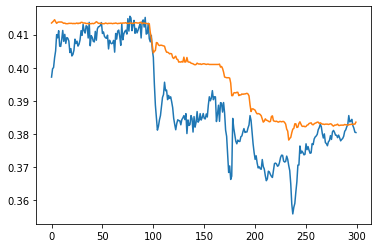

In [90]:
plt.plot(X_predict[:300])
plt.plot(y_train[:300])

In [78]:
X_train[0]

array([0.4177, 0.4176, 0.4172, 0.4173, 0.4172, 0.4168, 0.4166, 0.4163,
       0.4154, 0.4157, 0.4158, 0.4153, 0.4153, 0.4151, 0.4149, 0.4141,
       0.4139, 0.4139, 0.4138, 0.4137, 0.4135, 0.4135, 0.4135, 0.4138,
       0.4141, 0.4135, 0.4141, 0.4139, 0.4139, 0.4133, 0.4133, 0.4134,
       0.4134, 0.4134, 0.4133, 0.4133, 0.4136, 0.4139, 0.4139, 0.4135,
       0.4133, 0.4136, 0.4135, 0.4134, 0.4134, 0.4134, 0.4134, 0.4133,
       0.4133, 0.4135, 0.4133, 0.4134, 0.4134, 0.4133, 0.4133, 0.4133,
       0.4135, 0.4134, 0.4133])